<a href="https://colab.research.google.com/github/SLKS99/Understanding-the-Ligand-Assisted-Reprecipitation-of-CsPbBr3-Perovskite-Nanocrystals-via-High-Throug/blob/main/OctA_OctAm_CsPbBr3_Tol_Chloro_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

January 5, 2023


Contributions:
- Data by Mahshid Ahmadi and Sheryl Sanchez, Jonghee Yang
- Analysis by Sheryl Sanchez and Jonghee Yang


In [1]:
#@title Import Modules 

import numpy as np
import pandas as pd


#Plotting Tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

import seaborn as sns

#gdown Installation
!pip install gdown==3.6.0

!pip install lmfit

from lmfit.models import GaussianModel, ExponentialModel, ConstantModel
import lmfit

from lmfit import Model
from lmfit import minimize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## User Input

In [2]:
#@title Experimental Data 

#Wells that we should ignore
wells_to_ignore = 'A11,A12,B11,B12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,G11,G12,H11,H12' #@param {type:"string"}

#Information about Measurement Range
start_wavelength = 400 #@param {type:"integer"}
end_wavelength =  650 #@param {type:"integer"}
wavelength_step_size =  2 #@param {type:"integer"}

time_step = 16 #@param {type:"integer"}A

#Information about the reads
number_of_reads =   44#@param {type:"integer"}
luminescence_read_numbers = '2,4,6,8,10,12,14,16,19,21,23,25,27,29,31,34,36,38,40,42'
#,93,94,95,96,97,98,99,100,101,102,103' #@param {type:"string"}

#Convert the string into a list to use later 
if len(wells_to_ignore) != 0:
  wells_to_ignore = list(wells_to_ignore.split(","))
luminescence_read_numbers = list(luminescence_read_numbers.split(","))

In [3]:
#@title Data Information

#Name of files 
data_file_name = '8-13-22 CsPbBr3 Octanoic Chloro Tol .csv' #@param {type:'string'}
composition_file_name = 'CsPbBr3 wells.csv' #@param {type:'string'}

#Download the correct data
data_file = '14O_wvRZmsjtcP8OVuSZWm4CtooVRrI6i' #@param {type:"string"}
composition_file = '1z-s5yzD9nsAB9QVAyUcleWxB_RCQvUkt' #@param {type:"string"}

## Downloading and Formating Data

---



In [4]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file}

!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=14O_wvRZmsjtcP8OVuSZWm4CtooVRrI6i
To: /content/8-13-22 CsPbBr3 Octanoic Chloro Tol .csv
100% 1.42M/1.42M [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z-s5yzD9nsAB9QVAyUcleWxB_RCQvUkt
To: /content/CsPbBr3 wells.csv
100% 3.15k/3.15k [00:00<00:00, 5.46MB/s]


In [5]:
#@title Into Pandas Dataframes
rawData = pd.read_csv(data_file_name,header=None)
rawData = rawData.replace('OVRFLW', np.nan)
rawData = rawData.replace(r'^\s*$', np.nan, regex=True)
composition = pd.read_csv(composition_file_name, index_col = 0)



In [6]:
#@title Parsing the Data into a Dictionary
cells = [] 

for i in range(1, 9):
  for j in range(1 , 13): 
    cells.append(chr(64 + i) + str(j))

for i in wells_to_ignore:
  cells.remove(i)

for i in wells_to_ignore: 
  composition = composition.drop(i, axis = 1)
if not luminescence_read_numbers:
  for i in luminescence_read_numbers:
    cells= cells.remove(i)

# This is to drop the compostions I want removed
#First the rows of measurements 
rows = []

for i in range(1, number_of_reads + 1): 
  rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':Spectrum'].index.tolist()
  rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':EM Spectrum'].index.tolist()

rows += rawData[rawData[rawData.columns[0]] == 'Results'].index.tolist()

#Separate into different dataframes 

#First step, make a list of the names 
names = []

for i in range(1, number_of_reads + 1):
  names.append('Read ' + str(i))

#Next, make a dictionary 
d = {}

for c in names:
  split_name = c.split(' ')
  index = int(split_name[1])
  d[c] = rawData[rows[index - 1] + 2 :rows[index] - 1] #Take a section of the values 
  d[c] = d[c].drop([0], axis = 1) #Drop the empty column
  new_header = d[c].iloc[0] #grab the first row for the header
  d[c] = d[c][1:] #take the data less the header row
  d[c].columns = new_header #set the header row as the df header
  for i in wells_to_ignore: 
    d[c] = d[c].drop(i, axis = 1)
  d[c] = d[c].astype(float) #Make sure that it is composed of numbers
  

In [7]:
#@title Convert the Dictionary into an Array
#Convert  into an array
luminescence_time = np.array(luminescence_read_numbers)
luminescence_time = [int(i) * time_step for i in luminescence_time]

#Convert wavelength information into an array
luminescence_wavelength = np.arange(start_wavelength,end_wavelength + wavelength_step_size,wavelength_step_size)

#Make a grid
nx, ny = np.meshgrid(luminescence_wavelength, luminescence_time)

#Load information into a dataframe
luminescence_df = pd.DataFrame()

for i in luminescence_read_numbers:
  
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])

luminescence_df.insert(loc = 0, column = 'Time', value = ny.ravel())

luminescence_df = luminescence_df.fillna(0.0)

luminescence_vec = np.array(luminescence_df)


In [8]:
luminescence_vec.shape

(2520, 42)

## Plotting Reads

Text(0, 0.5, 'Intensity (a.u.)')

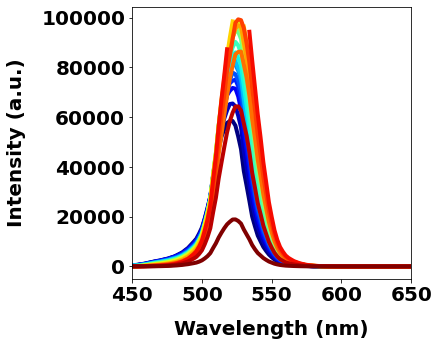

In [9]:
#@title Single Well
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Calibri'] + plt.rcParams['font.sans-serif']
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.titleweight']='bold'


well = 'A5' #@param {type:"string"}

#Define the figure
fig1 = plt.figure(figsize=(5,5))
ax1 = fig1.add_subplot(111)

colors = cm.jet(np.linspace(0, 1, len(luminescence_read_numbers)))

color_holder = 0

for i in luminescence_read_numbers:
 
  plot_row = 0
  plot_column = 0
      
  d['Read ' + str(i)].plot(x = 'Wavelength', y = well, ax = ax1, legend = False, linewidth=4, c = colors[color_holder])
  color_holder += 1
plt.xlim(450,650)
#plt.ylim(-1000,25000)
#plt.title('1:2 OctA:OctAm')
plt.xlabel('Wavelength (nm)', labelpad=15)
plt.ylabel('Intensity (a.u.)', labelpad=15)

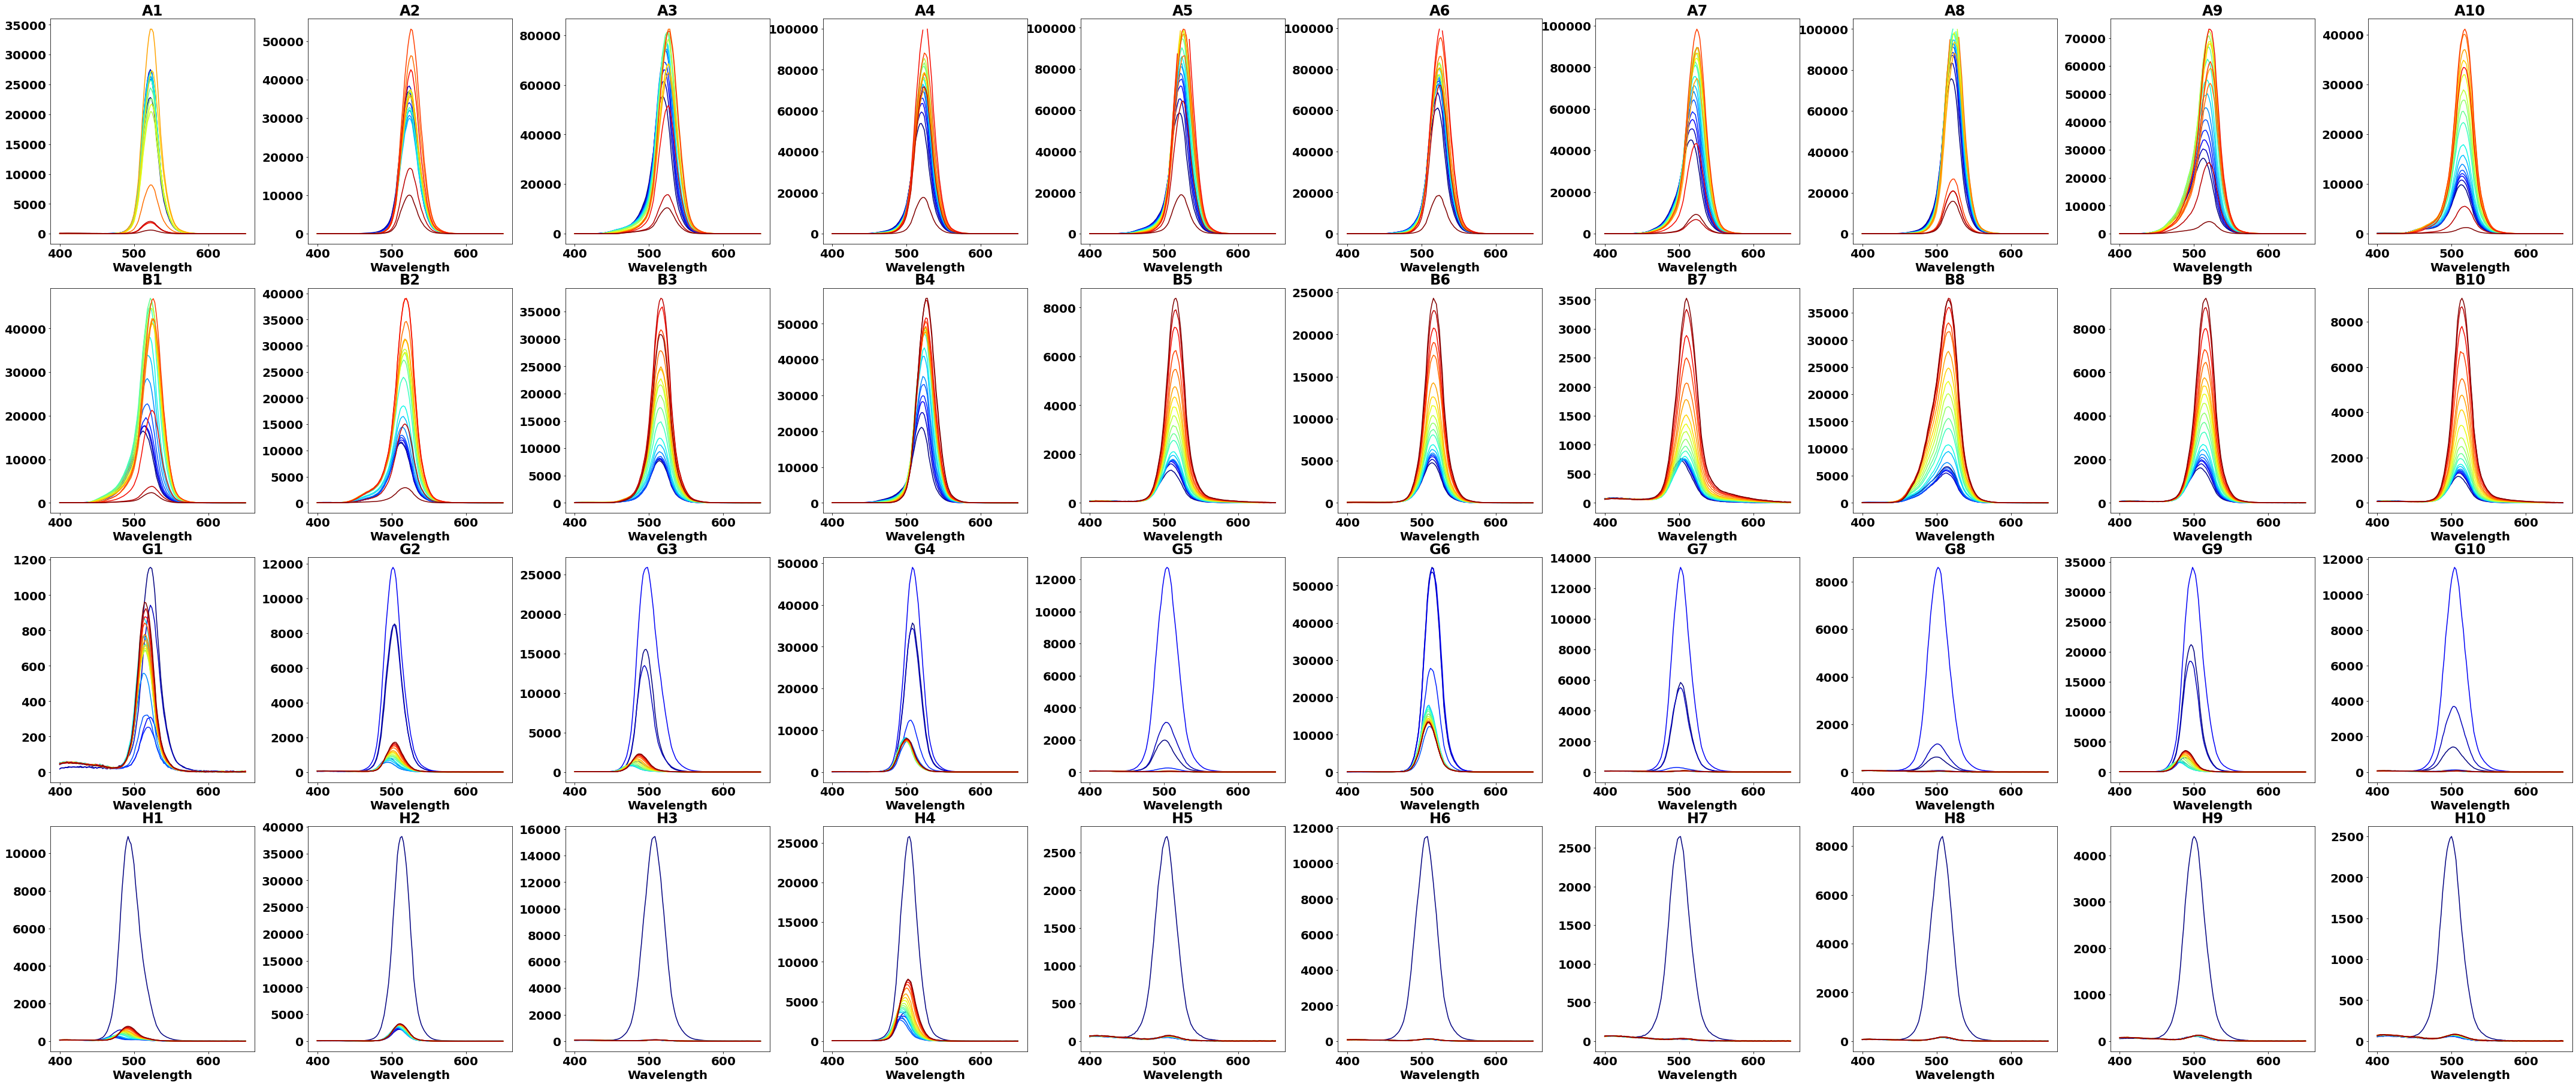

In [11]:
#@title Time Evolution for Luminescence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Calibri'] + plt.rcParams['font.sans-serif']
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.titleweight']='bold'

num_of_rows = 4
num_of_cols = 10

#Define the figure
fig, axes = plt.subplots(nrows = num_of_rows , ncols = num_of_cols, figsize = (60,25))
fig.tight_layout(h_pad=2)

colors = cm.jet(np.linspace(0, 1, len(luminescence_read_numbers)))

for i in range(len(luminescence_read_numbers)): 
  
  plot_row = 0
  plot_column = 0

  for j in range(len(cells)): 
    if cells[j] not in wells_to_ignore:
      d['Read '+ str(luminescence_read_numbers[i])].plot(x = 'Wavelength', y = cells[j], ax = axes[plot_row, plot_column], title = str(cells[j]), legend = False, c = colors[i])
    

    #Putting the plots where they need to be 
    plot_column += 1
    if plot_column == 10:
      plot_row += 1
      plot_column = 0
plt.savefig('OCtA OctAm Time evolution plot.tif', bbox_inches='tight',dpi=300)

In [12]:
luminescence_vec.shape

(2520, 42)

In [13]:
luminescence_wavelength.shape

(126,)

In [14]:
ldata = luminescence_vec.reshape([20,126,42])
print(ldata.shape, luminescence_wavelength.shape)
print(luminescence_wavelength.max())

(20, 126, 42) (126,)
650


In [15]:
luminescence_wavelength

array([400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420, 422, 424,
       426, 428, 430, 432, 434, 436, 438, 440, 442, 444, 446, 448, 450,
       452, 454, 456, 458, 460, 462, 464, 466, 468, 470, 472, 474, 476,
       478, 480, 482, 484, 486, 488, 490, 492, 494, 496, 498, 500, 502,
       504, 506, 508, 510, 512, 514, 516, 518, 520, 522, 524, 526, 528,
       530, 532, 534, 536, 538, 540, 542, 544, 546, 548, 550, 552, 554,
       556, 558, 560, 562, 564, 566, 568, 570, 572, 574, 576, 578, 580,
       582, 584, 586, 588, 590, 592, 594, 596, 598, 600, 602, 604, 606,
       608, 610, 612, 614, 616, 618, 620, 622, 624, 626, 628, 630, 632,
       634, 636, 638, 640, 642, 644, 646, 648, 650])

Text(42.0, 0.5, 'Time (min)')

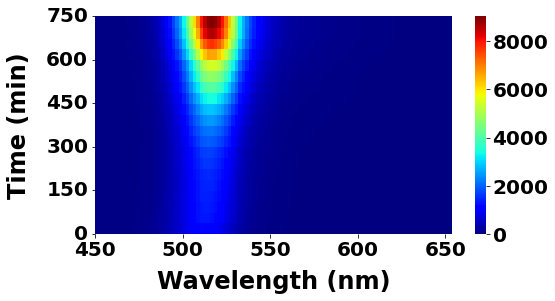

In [16]:

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 20
plt.figure(figsize=(8,4))
ax2=sns.heatmap(ldata[:,:,21], cmap='jet')
ax2.invert_yaxis()
ax2.set_yticks([0,4,8,12,16,20])

ax2.set_yticklabels([0,150,300,450,600,750],rotation='horizontal')
ax2.set_xlim(24, 126)
ax2.set_xticks(np.arange(24,len(luminescence_wavelength),25))
ax2.set_xticklabels([450,500,550,600,650], rotation='horizontal')
ax2.set_xlabel('Wavelength (nm)', labelpad=10, size=24)
ax2.set_ylabel('Time (min)', labelpad=15, size=24)

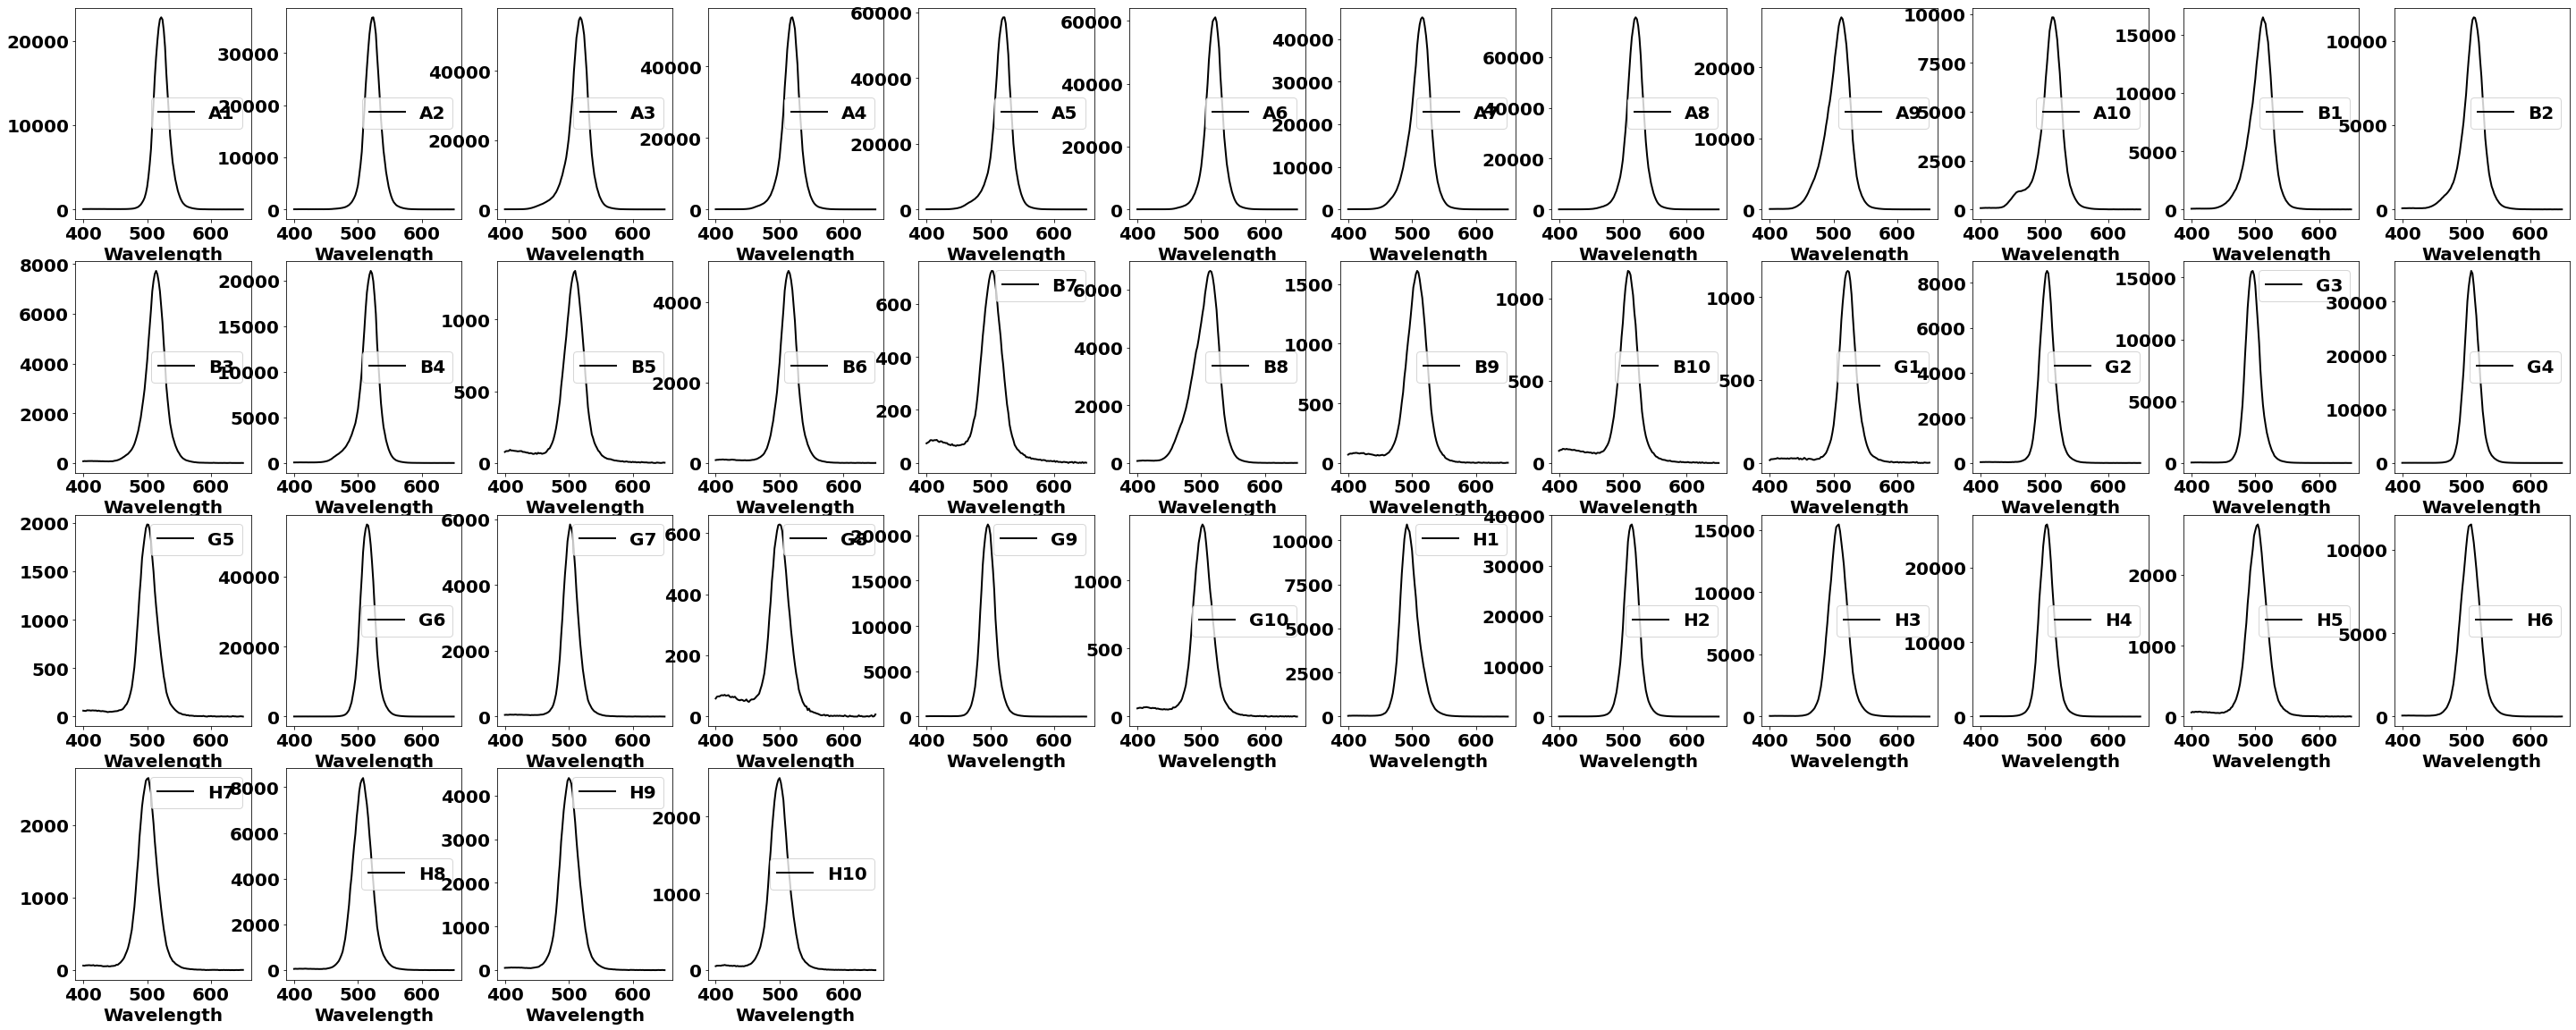

In [17]:
d['Read 2'].plot(x='Wavelength',subplots=True,layout=(4,12),figsize=(50,20),sharex=False,color='Black',linewidth=2)
plt.show()

### Read One Gaussian Fit

In [18]:
d['Read 2'] = d['Read 2'].drop(['Wavelength'], axis = 1)

In [19]:
d['Read 2']

537    A1    A2    A3    A4    A5    A6    A7    A8    A9   A10  ...    H1  \
538  38.0  26.0  35.0  36.0  34.0  33.0  45.0  24.0  56.0  68.0  ...  40.0   
539  43.0  31.0  37.0  44.0  35.0  36.0  46.0  30.0  61.0  69.0  ...  49.0   
540  46.0  28.0  39.0  45.0  38.0  34.0  49.0  30.0  60.0  74.0  ...  46.0   
541  45.0  32.0  41.0  45.0  40.0  38.0  49.0  30.0  63.0  76.0  ...  51.0   
542  46.0  37.0  42.0  46.0  43.0  42.0  52.0  34.0  65.0  80.0  ...  52.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
659   0.0   1.0   1.0   2.0   3.0   1.0   3.0   2.0   2.0   0.0  ...   1.0   
660   0.0   0.0   0.0   3.0   0.0   0.0   2.0   0.0   4.0   4.0  ...   2.0   
661   3.0   2.0   0.0   1.0   3.0   1.0   1.0   1.0   1.0   0.0  ...   0.0   
662   0.0   0.0   1.0   0.0   1.0   0.0   3.0   6.0   0.0   2.0  ...   0.0   
663   0.0   3.0   4.0   1.0   2.0   0.0   2.0   6.0   0.0   0.0  ...   0.0   

537    H2    H3    H4    H5    H6    H7    H8    H9   H10  
538  29.0  51.0  37.0  59.0  59.0  63.0  55.0  52.0  52.0  
539  28.0  46.0  41.0  67.0  60.0  61.0  61.0  55.0  58.0  
540  28.0  51.0  42.0  61.0  62.0  66.0  58.0  55.0  58.0  
541  33.0  53.0  41.0  68.0  58.0  66.0  57.0  57.0  59.0  
542  36.0  58.0  43.0  67.0  61.0  68.0  63.0  57.0  57.0  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
659   3.0   1.0   0.0   0.0   0.0   1.0   0.0   2.0   2.0  
660   1.0   0.0   3.0   2.0   1.0   1.0   0.0   1.0   3.0  
661   3.0   0.0   0.0   2.0   3.0   3.0   2.0   4.0   1.0  
662   0.0   2.0   0.0   4.0   2.0   3.0   0.0   2.0   0.0  
663   0.0   1.0   4.0   0.0   5.0   3.0   5.0   0.0   0.0  

[126 rows x 40 columns]

In [20]:
Readone= np.array(d['Read 2'])
Readone

array([[38., 26., 35., ..., 55., 52., 52.],
       [43., 31., 37., ..., 61., 55., 58.],
       [46., 28., 39., ..., 58., 55., 58.],
       ...,
       [ 3.,  2.,  0., ...,  2.,  4.,  1.],
       [ 0.,  0.,  1., ...,  0.,  2.,  0.],
       [ 0.,  3.,  4., ...,  5.,  0.,  0.]])

{'amplitude': 615187.7469451107, 'center': 521.6743530146915, 'sigma': 10.768616622446475, 'fwhm': 25.35815379486941, 'height': 22790.709642920094}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 126
    # variables        = 3
    chi-square         = 11409066.0
    reduced chi-square = 92756.6344
    Akaike info crit   = 1444.11826
    Bayesian info crit = 1452.62710
    R-squared          = 0.99726025
[[Variables]]
    amplitude:  615187.747 +/- 3259.24321 (0.53%) (init = 752895)
    center:     521.674353 +/- 0.06587788 (0.01%) (init = 521)
    sigma:      10.7686166 +/- 0.06587788 (0.61%) (init = 11)
    fwhm:       25.3581538 +/- 0.15513054 (0.61%) == '2.3548200*sigma'
    height:     22790.7096 +/- 120.744609 (0.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


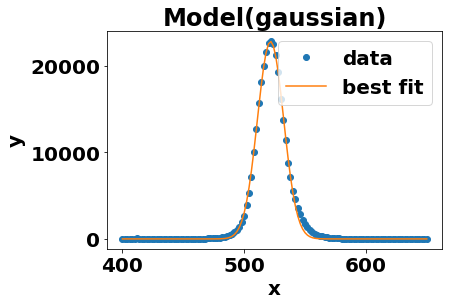

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 1039984.1521457258, 'center': 522.8262247929472, 'sigma': 11.335076354617096, 'fwhm': 26.69206450137943, 'height': 36602.63562773161}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 22234776.2
    reduced chi-square = 180770.538
    Akaike info crit   = 1528.19166
    Bayesian info crit = 1536.70051
    R-squared          = 0.99801226
[[Variables]]
    amplitude:  1039984.15 +/- 4668.10391 (0.45%) (init = 1326996)
    center:     522.826225 +/- 0.05875015 (0.01%) (init = 522)
    sigma:      11.3350764 +/- 0.05875015 (0.52%) (init = 12)
    fwhm:       26.6920645 +/- 0.13834602 (0.52%) == '2.3548200*sigma'
    height:     36602.6356 +/- 164.296022 (0.45%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


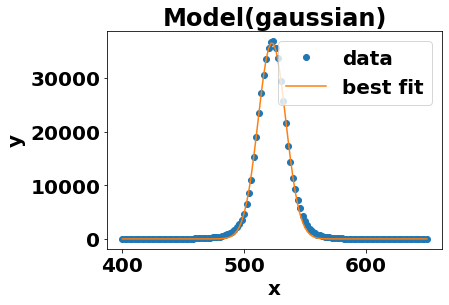

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 1750003.8050357043, 'center': 517.3156550824281, 'sigma': 12.883800278054334, 'fwhm': 30.33903057076791, 'height': 54188.246318820435}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 3.2326e+08
    reduced chi-square = 2628119.03
    Akaike info crit   = 1865.46786
    Bayesian info crit = 1873.97670
    R-squared          = 0.98795053
[[Variables]]
    amplitude:  1750003.81 +/- 18976.2231 (1.08%) (init = 2164266)
    center:     517.315655 +/- 0.16131929 (0.03%) (init = 517)
    sigma:      12.8838003 +/- 0.16131929 (1.25%) (init = 13)
    fwhm:       30.3390306 +/- 0.37987788 (1.25%) == '2.3548200*sigma'
    height:     54188.2463 +/- 587.593943 (1.08%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


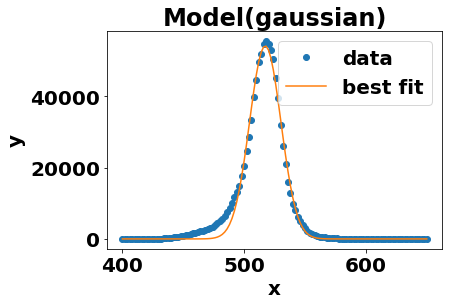

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 1578776.277458683, 'center': 518.8530334328377, 'sigma': 11.845620073632555, 'fwhm': 27.894303061791415, 'height': 53170.7614628619}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 1.2745e+08
    reduced chi-square = 1036149.39
    Akaike info crit   = 1748.19247
    Bayesian info crit = 1756.70131
    R-squared          = 0.99475599
[[Variables]]
    amplitude:  1578776.28 +/- 11424.9656 (0.72%) (init = 2097498)
    center:     518.853033 +/- 0.09898359 (0.02%) (init = 519)
    sigma:      11.8456201 +/- 0.09898358 (0.84%) (init = 13)
    fwhm:       27.8943031 +/- 0.23308852 (0.84%) == '2.3548200*sigma'
    height:     53170.7615 +/- 384.776302 (0.72%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


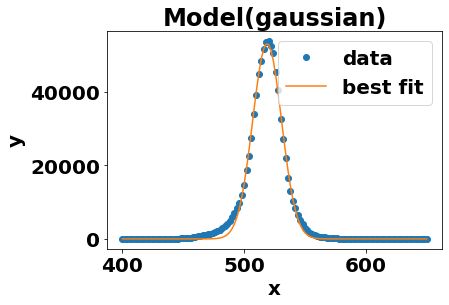

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 1756292.8890328945, 'center': 519.4959091586028, 'sigma': 12.108977492788988, 'fwhm': 28.514462379569366, 'height': 57862.815009911224}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 2.8187e+08
    reduced chi-square = 2291651.49
    Akaike info crit   = 1848.20640
    Bayesian info crit = 1856.71525
    R-squared          = 0.99032241
[[Variables]]
    amplitude:  1756292.89 +/- 17178.6855 (0.98%) (init = 2105604)
    center:     519.495909 +/- 0.13676300 (0.03%) (init = 520)
    sigma:      12.1089775 +/- 0.13676301 (1.13%) (init = 12)
    fwhm:       28.5144624 +/- 0.32205227 (1.13%) == '2.3548200*sigma'
    height:     57862.8150 +/- 565.967845 (0.98%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


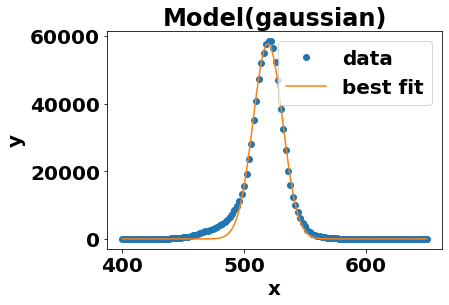

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 1803234.944735939, 'center': 520.3942964456184, 'sigma': 11.827445903814874, 'fwhm': 27.851506163221345, 'height': 60823.50341262558}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1.1426e+08
    reduced chi-square = 928961.501
    Akaike info crit   = 1734.43335
    Bayesian info crit = 1742.94220
    R-squared          = 0.99641073
[[Variables]]
    amplitude:  1803234.94 +/- 10809.5871 (0.60%) (init = 2201112)
    center:     520.394296 +/- 0.08186887 (0.02%) (init = 520)
    sigma:      11.8274459 +/- 0.08186887 (0.69%) (init = 12)
    fwhm:       27.8515062 +/- 0.19278645 (0.69%) == '2.3548200*sigma'
    height:     60823.5034 +/- 364.610633 (0.60%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


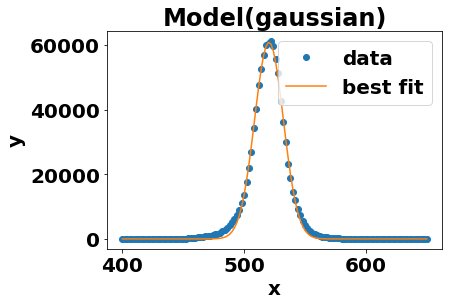

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 1562033.824784499, 'center': 514.2058775676526, 'sigma': 14.233864734272489, 'fwhm': 33.51818935355954, 'height': 43780.194512939896}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 2.7848e+08
    reduced chi-square = 2264054.75
    Akaike info crit   = 1846.67986
    Bayesian info crit = 1855.18871
    R-squared          = 0.98540992
[[Variables]]
    amplitude:  1562033.82 +/- 18512.5764 (1.19%) (init = 1895418)
    center:     514.205878 +/- 0.19479039 (0.04%) (init = 514)
    sigma:      14.2338647 +/- 0.19479040 (1.37%) (init = 14)
    fwhm:       33.5181894 +/- 0.45869632 (1.37%) == '2.3548200*sigma'
    height:     43780.1945 +/- 518.863818 (1.19%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


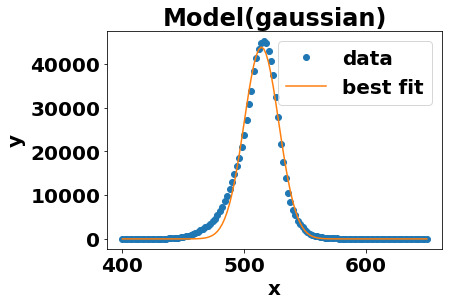

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 2266853.7336384603, 'center': 519.5302041965919, 'sigma': 12.015512811172666, 'fwhm': 28.294369878005618, 'height': 75264.68961194961}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1.8373e+08
    reduced chi-square = 1493713.29
    Akaike info crit   = 1794.27745
    Bayesian info crit = 1802.78629
    R-squared          = 0.99627866
[[Variables]]
    amplitude:  2266853.73 +/- 13815.5191 (0.61%) (init = 2726928)
    center:     519.530204 +/- 0.08455800 (0.02%) (init = 520)
    sigma:      12.0155128 +/- 0.08455801 (0.70%) (init = 12)
    fwhm:       28.2943699 +/- 0.19911888 (0.70%) == '2.3548200*sigma'
    height:     75264.6896 +/- 458.706134 (0.61%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


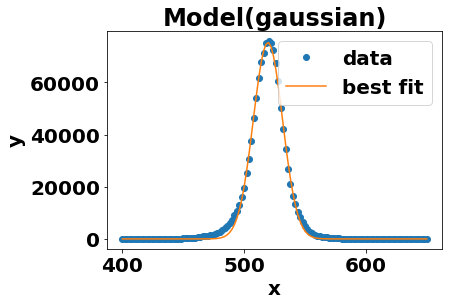

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 1076524.4380826864, 'center': 509.06680402427776, 'sigma': 16.76502555415793, 'fwhm': 39.47861747544218, 'height': 25617.088023370205}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 1.7086e+08
    reduced chi-square = 1389130.09
    Akaike info crit   = 1785.13143
    Bayesian info crit = 1793.64028
    R-squared          = 0.97692930
[[Variables]]
    amplitude:  1076524.44 +/- 15737.5774 (1.46%) (init = 1379040)
    center:     509.066804 +/- 0.28300153 (0.06%) (init = 509)
    sigma:      16.7650256 +/- 0.28300152 (1.69%) (init = 17)
    fwhm:       39.4786175 +/- 0.66641765 (1.69%) == '2.3548200*sigma'
    height:     25617.0880 +/- 374.493723 (1.46%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


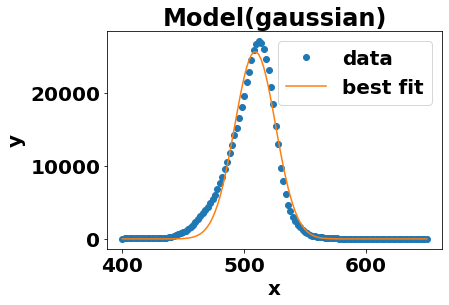

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 333545.12639029056, 'center': 512.4979738799884, 'sigma': 13.957902256502974, 'fwhm': 32.86834739165833, 'height': 9533.327962225716}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 17755930.0
    reduced chi-square = 144357.155
    Akaike info crit   = 1499.84947
    Bayesian info crit = 1508.35832
    R-squared          = 0.97954203
[[Variables]]
    amplitude:  333545.126 +/- 4629.07838 (1.39%) (init = 442260)
    center:     512.497974 +/- 0.22368232 (0.04%) (init = 513)
    sigma:      13.9579023 +/- 0.22368231 (1.60%) (init = 15)
    fwhm:       32.8683474 +/- 0.52673158 (1.60%) == '2.3548200*sigma'
    height:     9533.32796 +/- 132.307945 (1.39%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


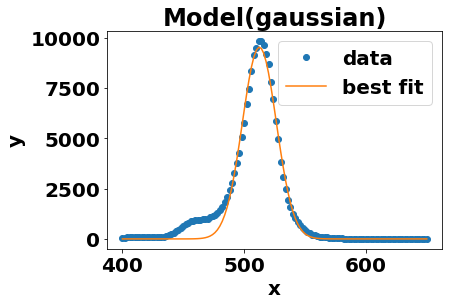

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 617560.2551049446, 'center': 510.4620681795414, 'sigma': 15.62732616154344, 'fwhm': 36.799540191725725, 'height': 15765.391085676325}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 42244812.7
    reduced chi-square = 343453.762
    Akaike info crit   = 1609.06149
    Bayesian info crit = 1617.57033
    R-squared          = 0.98408073
[[Variables]]
    amplitude:  617560.255 +/- 7555.11241 (1.22%) (init = 792480)
    center:     510.462068 +/- 0.22075828 (0.04%) (init = 510)
    sigma:      15.6273262 +/- 0.22075828 (1.41%) (init = 16)
    fwhm:       36.7995402 +/- 0.51984601 (1.41%) == '2.3548200*sigma'
    height:     15765.3911 +/- 192.871140 (1.22%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


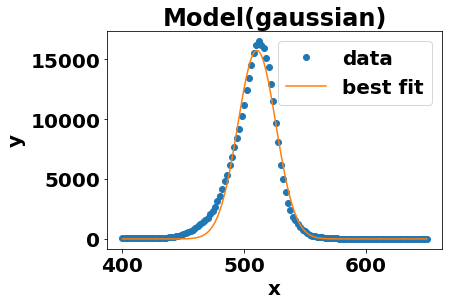

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 386851.29368742, 'center': 512.0994673845016, 'sigma': 13.899410862715817, 'fwhm': 32.73061068774046, 'height': 11103.445058640415}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 14148839.4
    reduced chi-square = 115031.215
    Akaike info crit   = 1471.23652
    Bayesian info crit = 1479.74536
    R-squared          = 0.98809815
[[Variables]]
    amplitude:  386851.294 +/- 4123.53963 (1.07%) (init = 479430)
    center:     512.099467 +/- 0.17107751 (0.03%) (init = 512)
    sigma:      13.8994109 +/- 0.17107751 (1.23%) (init = 14)
    fwhm:       32.7306107 +/- 0.40285674 (1.23%) == '2.3548200*sigma'
    height:     11103.4451 +/- 118.354440 (1.07%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


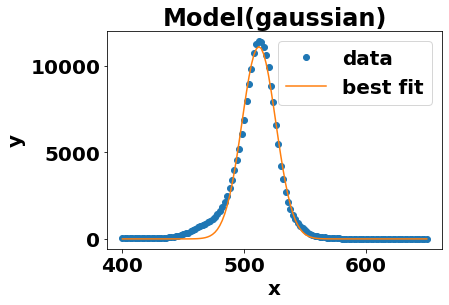

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 250654.9850014074, 'center': 513.5386523361007, 'sigma': 13.330822882269548, 'fwhm': 31.39168833962598, 'height': 7501.178067253917}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 3775322.82
    reduced chi-square = 30693.6815
    Akaike info crit   = 1304.77203
    Bayesian info crit = 1313.28088
    R-squared          = 0.99282487
[[Variables]]
    amplitude:  250654.985 +/- 2086.01629 (0.83%) (init = 324366)
    center:     513.538652 +/- 0.12810595 (0.02%) (init = 514)
    sigma:      13.3308229 +/- 0.12810595 (0.96%) (init = 14)
    fwhm:       31.3916883 +/- 0.30166645 (0.96%) == '2.3548200*sigma'
    height:     7501.17807 +/- 62.4269188 (0.83%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


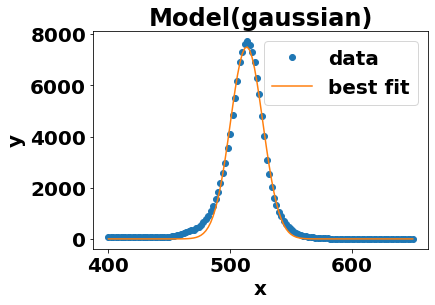

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 620433.9728842943, 'center': 519.0658988152759, 'sigma': 12.045579636379827, 'fwhm': 28.365171839339947, 'height': 20548.397305269635}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 52122643.2
    reduced chi-square = 423761.326
    Akaike info crit   = 1635.53634
    Bayesian info crit = 1644.04519
    R-squared          = 0.98572528
[[Variables]]
    amplitude:  620433.973 +/- 7367.78197 (1.19%) (init = 759168)
    center:     519.065899 +/- 0.16517238 (0.03%) (init = 520)
    sigma:      12.0455796 +/- 0.16517239 (1.37%) (init = 12)
    fwhm:       28.3651718 +/- 0.38895124 (1.37%) == '2.3548200*sigma'
    height:     20548.3973 +/- 244.016164 (1.19%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


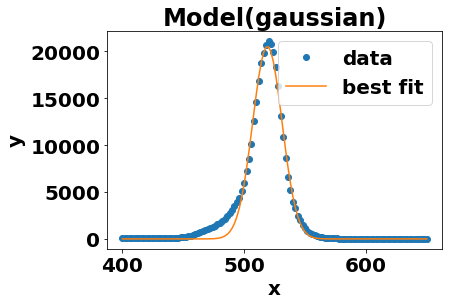

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 48761.774318171716, 'center': 508.274417126889, 'sigma': 14.938095071168522, 'fwhm': 35.176525035489064, 'height': 1302.2500061683334}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 243982.410
    reduced chi-square = 1983.59683
    Akaike info crit   = 959.639757
    Bayesian info crit = 968.148603
    R-squared          = 0.98531721
[[Variables]]
    amplitude:  48761.7743 +/- 561.355710 (1.15%) (init = 64272)
    center:     508.274417 +/- 0.19857473 (0.04%) (init = 508)
    sigma:      14.9380951 +/- 0.19857473 (1.33%) (init = 16)
    fwhm:       35.1765250 +/- 0.46760774 (1.33%) == '2.3548200*sigma'
    height:     1302.25001 +/- 14.9917905 (1.15%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


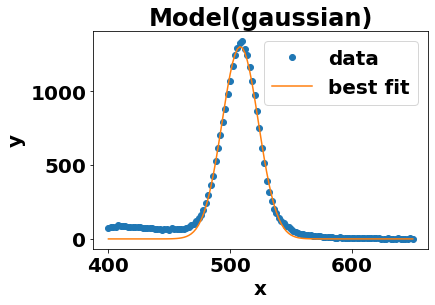

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 153702.0255217274, 'center': 513.7723679105399, 'sigma': 13.130702524775087, 'fwhm': 30.92044091939087, 'height': 4669.836930705042}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 1058205.47
    reduced chi-square = 8603.29654
    Akaike info crit   = 1144.51120
    Bayesian info crit = 1153.02005
    R-squared          = 0.99473469
[[Variables]]
    amplitude:  153702.026 +/- 1096.07562 (0.71%) (init = 200340)
    center:     513.772368 +/- 0.10812329 (0.02%) (init = 514)
    sigma:      13.1307025 +/- 0.10812329 (0.82%) (init = 14)
    fwhm:       30.9204409 +/- 0.25461089 (0.82%) == '2.3548200*sigma'
    height:     4669.83693 +/- 33.3014630 (0.71%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


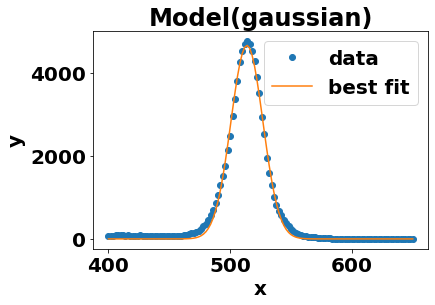

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 28575.995704140478, 'center': 501.96338199940857, 'sigma': 16.20930067378805, 'fwhm': 38.16998541264958, 'height': 703.3106289054817}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 186835.481
    reduced chi-square = 1518.98765
    Akaike info crit   = 926.014429
    Bayesian info crit = 934.523275
    R-squared          = 0.96243506
[[Variables]]
    amplitude:  28575.9957 +/- 511.713586 (1.79%) (init = 39096)
    center:     501.963382 +/- 0.33516897 (0.07%) (init = 502)
    sigma:      16.2093007 +/- 0.33516896 (2.07%) (init = 18)
    fwhm:       38.1699854 +/- 0.78926257 (2.07%) == '2.3548200*sigma'
    height:     703.310629 +/- 12.5943513 (1.79%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


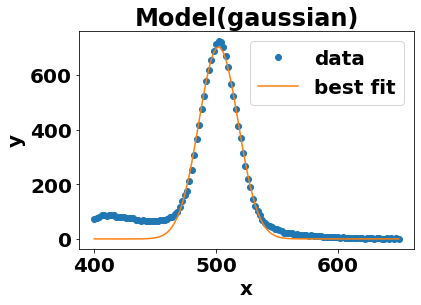

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 300752.2963033325, 'center': 509.21156240568325, 'sigma': 19.195511844555757, 'fwhm': 45.20197520179679, 'height': 6250.565954643329}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 14175058.6
    reduced chi-square = 115244.379
    Akaike info crit   = 1471.46979
    Bayesian info crit = 1479.97864
    R-squared          = 0.97070243
[[Variables]]
    amplitude:  300752.296 +/- 4850.34241 (1.61%) (init = 378993)
    center:     509.211562 +/- 0.35746382 (0.07%) (init = 509)
    sigma:      19.1955118 +/- 0.35746383 (1.86%) (init = 19)
    fwhm:       45.2019752 +/- 0.84176297 (1.86%) == '2.3548200*sigma'
    height:     6250.56595 +/- 100.805102 (1.61%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


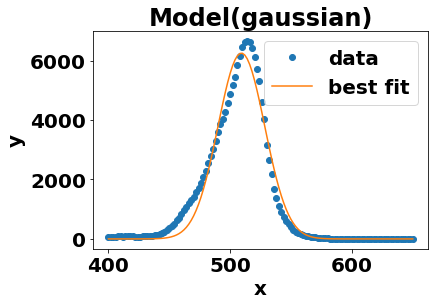

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 60086.40848706325, 'center': 507.3667498424263, 'sigma': 15.213234084755538, 'fwhm': 35.82442788746404, 'height': 1575.6682548248402}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 241747.717
    reduced chi-square = 1965.42859
    Akaike info crit   = 958.480376
    Bayesian info crit = 966.989222
    R-squared          = 0.99036631
[[Variables]]
    amplitude:  60086.4085 +/- 563.901239 (0.94%) (init = 82110)
    center:     507.366750 +/- 0.16486112 (0.03%) (init = 507)
    sigma:      15.2132341 +/- 0.16486112 (1.08%) (init = 17)
    fwhm:       35.8244279 +/- 0.38821827 (1.08%) == '2.3548200*sigma'
    height:     1575.66825 +/- 14.7874042 (0.94%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


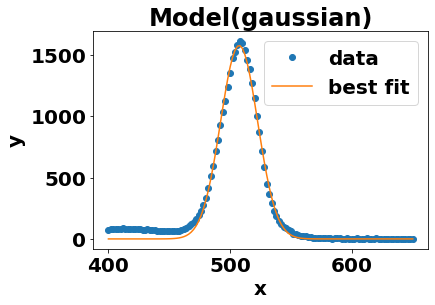

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 38849.08548791964, 'center': 509.20734278084257, 'sigma': 13.658624078342106, 'fwhm': 32.16360115216156, 'height': 1134.7075246051072}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 229525.589
    reduced chi-square = 1866.06170
    Akaike info crit   = 951.943475
    Bayesian info crit = 960.452320
    R-squared          = 0.98043872
[[Variables]]
    amplitude:  38849.0855 +/- 520.633264 (1.34%) (init = 49098)
    center:     509.207343 +/- 0.21136339 (0.04%) (init = 510)
    sigma:      13.6586241 +/- 0.21136338 (1.55%) (init = 14)
    fwhm:       32.1636012 +/- 0.49772272 (1.55%) == '2.3548200*sigma'
    height:     1134.70752 +/- 15.2067562 (1.34%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


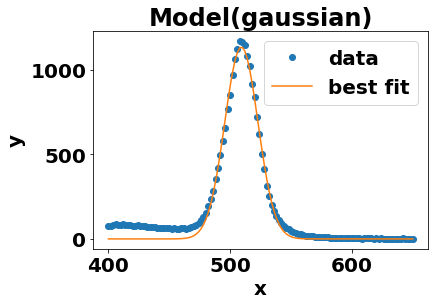

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 35464.89743660235, 'center': 521.6481179042119, 'sigma': 12.361859417699621, 'fwhm': 29.109953793987426, 'height': 1144.5242398052674}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 72244.8620
    reduced chi-square = 587.356602
    Akaike info crit   = 806.293357
    Bayesian info crit = 814.802203
    R-squared          = 0.99365531
[[Variables]]
    amplitude:  35464.8974 +/- 277.879493 (0.78%) (init = 45123)
    center:     521.648118 +/- 0.11184371 (0.02%) (init = 521)
    sigma:      12.3618594 +/- 0.11184371 (0.90%) (init = 13)
    fwhm:       29.1099538 +/- 0.26337180 (0.90%) == '2.3548200*sigma'
    height:     1144.52424 +/- 8.96774353 (0.78%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


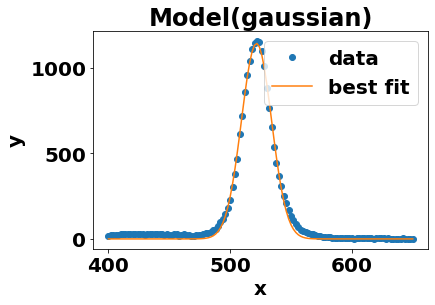

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 231900.90767144816, 'center': 503.8999033577531, 'sigma': 11.097331409712748, 'fwhm': 26.132217950219776, 'height': 8336.696279752712}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 1579739.21
    reduced chi-square = 12843.4082
    Akaike info crit   = 1194.99754
    Bayesian info crit = 1203.50639
    R-squared          = 0.99722720
[[Variables]]
    amplitude:  231900.908 +/- 1231.15531 (0.53%) (init = 306972)
    center:     503.899903 +/- 0.06802971 (0.01%) (init = 504)
    sigma:      11.0973314 +/- 0.06802971 (0.61%) (init = 12)
    fwhm:       26.1322180 +/- 0.16019773 (0.61%) == '2.3548200*sigma'
    height:     8336.69628 +/- 44.2593037 (0.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


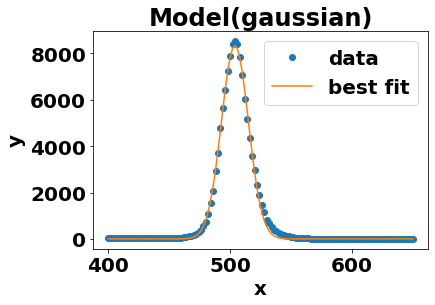

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 418077.1946018589, 'center': 495.68377374693165, 'sigma': 10.690109423214142, 'fwhm': 25.17328347197313, 'height': 15602.14877032247}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 6871973.83
    reduced chi-square = 55869.7059
    Akaike info crit   = 1380.24168
    Bayesian info crit = 1388.75053
    R-squared          = 0.99645670
[[Variables]]
    amplitude:  418077.195 +/- 2520.24376 (0.60%) (init = 512688)
    center:     495.683774 +/- 0.07441111 (0.02%) (init = 495)
    sigma:      10.6901094 +/- 0.07441111 (0.70%) (init = 11)
    fwhm:       25.1732835 +/- 0.17522476 (0.70%) == '2.3548200*sigma'
    height:     15602.1488 +/- 94.0525548 (0.60%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


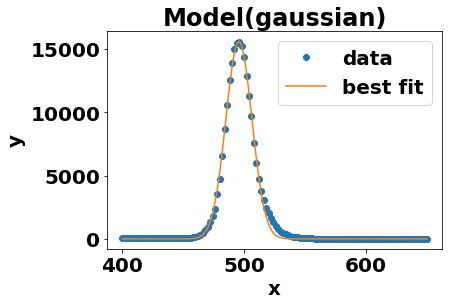

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 953759.355422848, 'center': 508.5584764553259, 'sigma': 10.846702963156995, 'fwhm': 25.542033071701354, 'height': 35079.31877468536}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 10759207.5
    reduced chi-square = 87473.2320
    Akaike info crit   = 1436.72881
    Bayesian info crit = 1445.23766
    R-squared          = 0.99891930
[[Variables]]
    amplitude:  953759.355 +/- 3176.50736 (0.33%) (init = 1177044)
    center:     508.558476 +/- 0.04171368 (0.01%) (init = 509)
    sigma:      10.8467030 +/- 0.04171368 (0.38%) (init = 11)
    fwhm:       25.5420331 +/- 0.09822820 (0.38%) == '2.3548200*sigma'
    height:     35079.3188 +/- 116.832161 (0.33%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


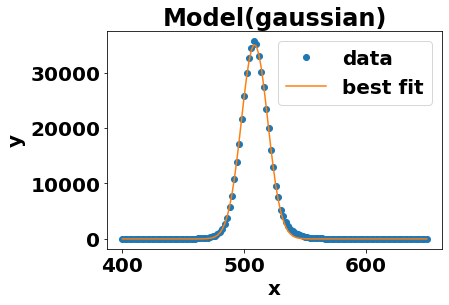

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 66132.40659103113, 'center': 500.92226331685225, 'sigma': 13.525669444067693, 'fwhm': 31.85051692027949, 'height': 1950.5884347582225}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 224921.521
    reduced chi-square = 1828.63026
    Akaike info crit   = 949.390340
    Bayesian info crit = 957.899186
    R-squared          = 0.99369351
[[Variables]]
    amplitude:  66132.4066 +/- 512.868697 (0.78%) (init = 89280)
    center:     500.922263 +/- 0.12112137 (0.02%) (init = 501)
    sigma:      13.5256694 +/- 0.12112137 (0.90%) (init = 15)
    fwhm:       31.8505169 +/- 0.28521902 (0.90%) == '2.3548200*sigma'
    height:     1950.58843 +/- 15.1271815 (0.78%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


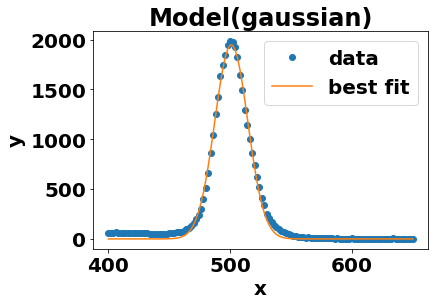

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 1484335.711400312, 'center': 514.7109089215943, 'sigma': 10.676875320198503, 'fwhm': 25.142119541509842, 'height': 55462.322535313375}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 30847705.3
    reduced chi-square = 250794.352
    Akaike info crit   = 1569.44467
    Bayesian info crit = 1577.95351
    R-squared          = 0.99874485
[[Variables]]
    amplitude:  1484335.71 +/- 5336.34892 (0.36%) (init = 1811601)
    center:     514.710909 +/- 0.04432266 (0.01%) (init = 515)
    sigma:      10.6768753 +/- 0.04432266 (0.42%) (init = 11)
    fwhm:       25.1421195 +/- 0.10437188 (0.42%) == '2.3548200*sigma'
    height:     55462.3225 +/- 199.393150 (0.36%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


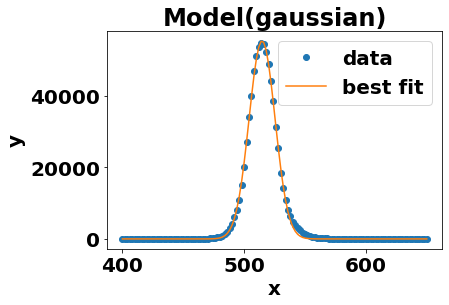

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 161574.4089608342, 'center': 502.6373132981816, 'sigma': 11.301710338922236, 'fwhm': 26.613493540300862, 'height': 5703.461192947439}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 790638.050
    reduced chi-square = 6427.95163
    Akaike info crit   = 1107.78352
    Bayesian info crit = 1116.29237
    R-squared          = 0.99706555
[[Variables]]
    amplitude:  161574.409 +/- 878.965179 (0.54%) (init = 210312)
    center:     502.637313 +/- 0.07099256 (0.01%) (init = 502)
    sigma:      11.3017103 +/- 0.07099256 (0.63%) (init = 12)
    fwhm:       26.6134935 +/- 0.16717470 (0.63%) == '2.3548200*sigma'
    height:     5703.46119 +/- 31.0268518 (0.54%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


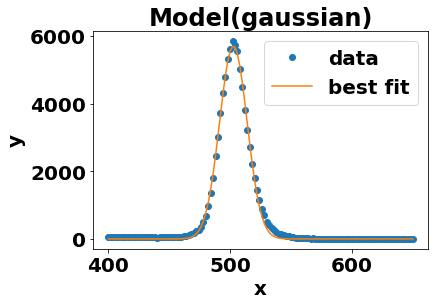

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 22724.02378360251, 'center': 500.0477986404496, 'sigma': 14.707499476413247, 'fwhm': 34.633513917047445, 'height': 616.3912722229743}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 125476.817
    reduced chi-square = 1020.13672
    Akaike info crit   = 875.852892
    Bayesian info crit = 884.361738
    R-squared          = 0.96530966
[[Variables]]
    amplitude:  22724.0238 +/- 399.451853 (1.76%) (init = 30144)
    center:     500.047799 +/- 0.29853149 (0.06%) (init = 500)
    sigma:      14.7074995 +/- 0.29853148 (2.03%) (init = 16)
    fwhm:       34.6335139 +/- 0.70298791 (2.03%) == '2.3548200*sigma'
    height:     616.391272 +/- 10.8352142 (1.76%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


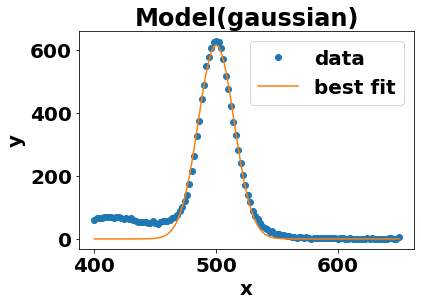

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 572165.1909306031, 'center': 496.0435052097638, 'sigma': 10.71530148484537, 'fwhm': 25.232606242543575, 'height': 21302.330837132573}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 8198217.51
    reduced chi-square = 66652.1748
    Akaike info crit   = 1402.47632
    Bayesian info crit = 1410.98517
    R-squared          = 0.99773995
[[Variables]]
    amplitude:  572165.191 +/- 2755.95789 (0.48%) (init = 763236)
    center:     496.043505 +/- 0.05959709 (0.01%) (init = 496)
    sigma:      10.7153015 +/- 0.05959709 (0.56%) (init = 12)
    fwhm:       25.2326062 +/- 0.14034042 (0.56%) == '2.3548200*sigma'
    height:     21302.3308 +/- 102.607323 (0.48%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


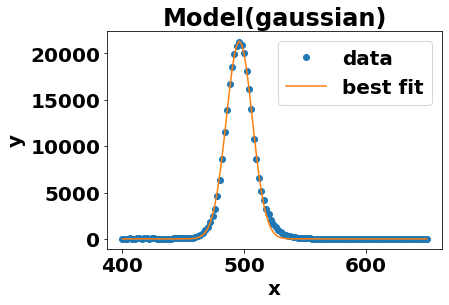

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 49505.81636056922, 'center': 502.13556278413006, 'sigma': 14.36341436730249, 'fwhm': 33.82325542041125, 'height': 1375.0187620586096}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 157079.602
    reduced chi-square = 1277.06994
    Akaike info crit   = 904.156485
    Bayesian info crit = 912.665331
    R-squared          = 0.99142467
[[Variables]]
    amplitude:  49505.8164 +/- 441.671939 (0.89%) (init = 67728)
    center:     502.135563 +/- 0.14796915 (0.03%) (init = 502)
    sigma:      14.3634144 +/- 0.14796915 (1.03%) (init = 16)
    fwhm:       33.8232554 +/- 0.34844071 (1.03%) == '2.3548200*sigma'
    height:     1375.01876 +/- 12.2674010 (0.89%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


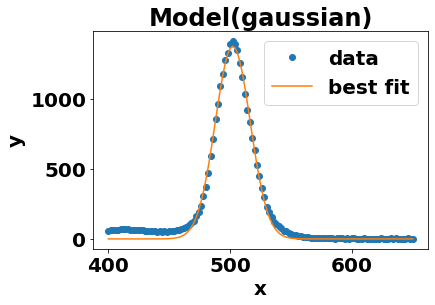

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 348328.2293536942, 'center': 494.6274008339799, 'sigma': 13.125392456554888, 'fwhm': 30.907936664544582, 'height': 10587.330278561805}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 10743151.5
    reduced chi-square = 87342.6954
    Akaike info crit   = 1436.54064
    Bayesian info crit = 1445.04948
    R-squared          = 0.98981118
[[Variables]]
    amplitude:  348328.229 +/- 3491.66994 (1.00%) (init = 424866)
    center:     494.627401 +/- 0.15192415 (0.03%) (init = 495)
    sigma:      13.1253925 +/- 0.15192415 (1.16%) (init = 13)
    fwhm:       30.9079367 +/- 0.35775403 (1.16%) == '2.3548200*sigma'
    height:     10587.3303 +/- 106.128345 (1.00%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


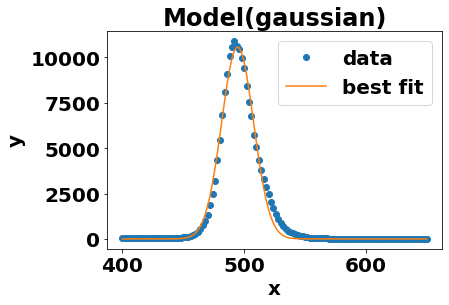

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 1073666.0642918136, 'center': 513.4911170038539, 'sigma': 11.186521250248326, 'fwhm': 26.342243970509763, 'height': 38289.90260140217}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 14752713.5
    reduced chi-square = 119940.760
    Akaike info crit   = 1476.50262
    Bayesian info crit = 1485.01146
    R-squared          = 0.99878502
[[Variables]]
    amplitude:  1073666.06 +/- 3777.41351 (0.35%) (init = 1375164)
    center:     513.491117 +/- 0.04544543 (0.01%) (init = 514)
    sigma:      11.1865213 +/- 0.04544543 (0.41%) (init = 12)
    fwhm:       26.3422440 +/- 0.10701581 (0.41%) == '2.3548200*sigma'
    height:     38289.9026 +/- 134.713120 (0.35%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


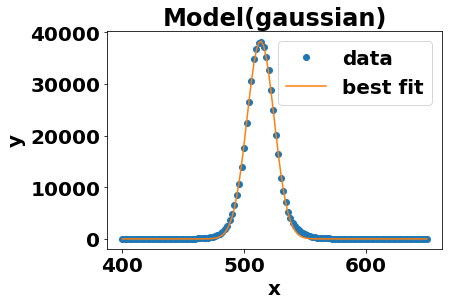

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 533540.9678559098, 'center': 506.6912318784375, 'sigma': 13.993147458276836, 'fwhm': 32.95134349769946, 'height': 15211.163999759214}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2385486.66
    reduced chi-square = 19394.2005
    Akaike info crit   = 1246.92761
    Bayesian info crit = 1255.43645
    R-squared          = 0.99895190
[[Variables]]
    amplitude:  533540.968 +/- 1698.85800 (0.32%) (init = 695160)
    center:     506.691232 +/- 0.05144870 (0.01%) (init = 507)
    sigma:      13.9931475 +/- 0.05144870 (0.37%) (init = 15)
    fwhm:       32.9513435 +/- 0.12115243 (0.37%) == '2.3548200*sigma'
    height:     15211.1640 +/- 48.4341820 (0.32%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


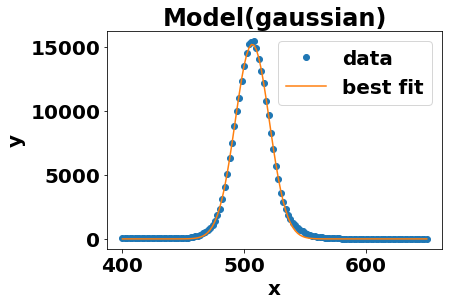

{'amplitude': 716882.3386431875, 'center': 503.2756131387089, 'sigma': 11.287579975878531, 'fwhm': 26.580219078798283, 'height': 25337.11297008398}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 10552251.2
    reduced chi-square = 85790.6606
    Akaike info crit   = 1434.28155
    Bayesian info crit = 1442.79040
    R-squared          = 0.99802895
[[Variables]]
    amplitude:  716882.339 +/- 3209.09486 (0.45%) (init = 851928)
    center:     503.275613 +/- 0.05834504 (0.01%) (init = 503)
    sigma:      11.2875800 +/- 0.05834504 (0.52%) (init = 11)
    fwhm:       26.5802191 +/- 0.13739206 (0.52%) == '2.3548200*sigma'
    height:     25337.1130 +/- 113.420396 (0.45%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


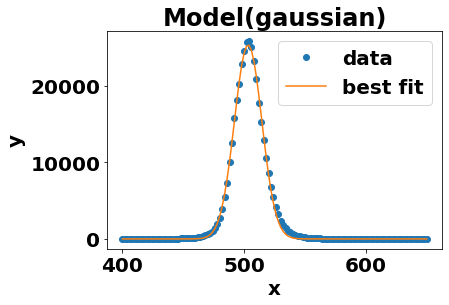

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 95886.55176675765, 'center': 502.63269479124153, 'sigma': 14.411671162488743, 'fwhm': 33.93689148685174, 'height': 2654.321006190197}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 210003.881
    reduced chi-square = 1707.34862
    Akaike info crit   = 940.743522
    Bayesian info crit = 949.252368
    R-squared          = 0.99698476
[[Variables]]
    amplitude:  95886.5518 +/- 511.543051 (0.53%) (init = 122040)
    center:     502.632695 +/- 0.08877875 (0.02%) (init = 503)
    sigma:      14.4116712 +/- 0.08877875 (0.62%) (init = 15)
    fwhm:       33.9368915 +/- 0.20905797 (0.62%) == '2.3548200*sigma'
    height:     2654.32101 +/- 14.1604961 (0.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


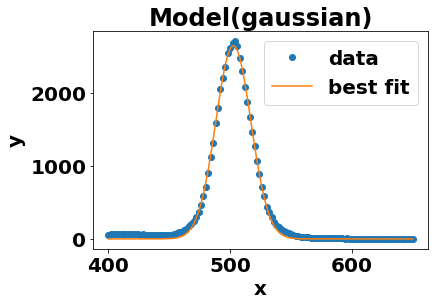

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 399742.6722740822, 'center': 506.298641476682, 'sigma': 14.091604150461592, 'fwhm': 33.18319128558997, 'height': 11316.969976050937}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1393278.70
    reduced chi-square = 11327.4691
    Akaike info crit   = 1179.17194
    Bayesian info crit = 1187.68078
    R-squared          = 0.99889879
[[Variables]]
    amplitude:  399742.672 +/- 1302.89684 (0.33%) (init = 552576)
    center:     506.298641 +/- 0.05303464 (0.01%) (init = 506)
    sigma:      14.0916042 +/- 0.05303464 (0.38%) (init = 16)
    fwhm:       33.1831913 +/- 0.12488703 (0.38%) == '2.3548200*sigma'
    height:     11316.9700 +/- 36.8858569 (0.33%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


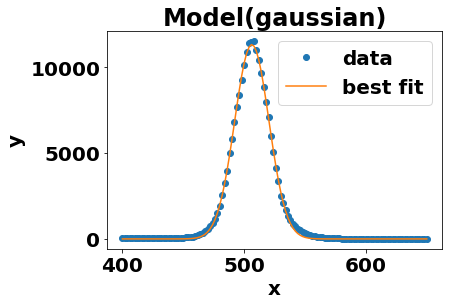

{'amplitude': 93412.3740096069, 'center': 500.29268124551, 'sigma': 14.292907804511152, 'fwhm': 33.657225156218956, 'height': 2607.3174084346083}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 257790.546
    reduced chi-square = 2095.85810
    Akaike info crit   = 966.576220
    Bayesian info crit = 975.085065
    R-squared          = 0.99613571
[[Variables]]
    amplitude:  93412.3740 +/- 564.422974 (0.60%) (init = 127056)
    center:     500.292681 +/- 0.09972191 (0.02%) (init = 500)
    sigma:      14.2929078 +/- 0.09972191 (0.70%) (init = 16)
    fwhm:       33.6572252 +/- 0.23482715 (0.70%) == '2.3548200*sigma'
    height:     2607.31741 +/- 15.7541296 (0.60%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


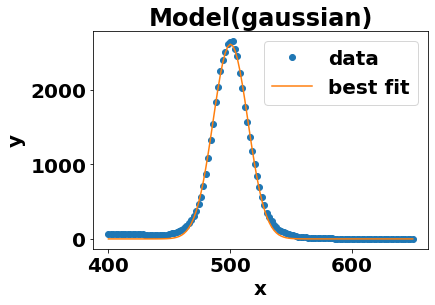

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 291339.4604573379, 'center': 506.63322468329653, 'sigma': 14.120961327625338, 'fwhm': 33.2523221535187, 'height': 8230.85849036561}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 819662.729
    reduced chi-square = 6663.92463
    Akaike info crit   = 1112.32616
    Bayesian info crit = 1120.83500
    R-squared          = 0.99877539
[[Variables]]
    amplitude:  291339.460 +/- 1000.36970 (0.34%) (init = 377820)
    center:     506.633225 +/- 0.05598802 (0.01%) (init = 507)
    sigma:      14.1209613 +/- 0.05598802 (0.40%) (init = 15)
    fwhm:       33.2523222 +/- 0.13184171 (0.40%) == '2.3548200*sigma'
    height:     8230.85849 +/- 28.2622362 (0.34%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


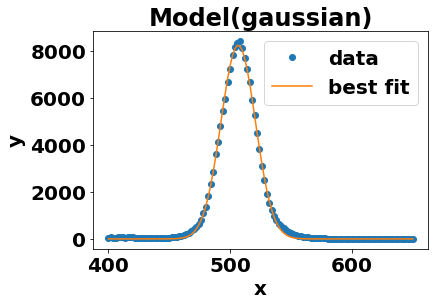

{'amplitude': 152364.99204737492, 'center': 500.72227124087374, 'sigma': 14.009233937226357, 'fwhm': 32.98922426005937, 'height': 4338.912508651852}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 487092.311
    reduced chi-square = 3960.10009
    Akaike info crit   = 1046.75081
    Bayesian info crit = 1055.25965
    R-squared          = 0.99734865
[[Variables]]
    amplitude:  152364.992 +/- 768.110252 (0.50%) (init = 198180)
    center:     500.722271 +/- 0.08154969 (0.02%) (init = 501)
    sigma:      14.0092339 +/- 0.08154969 (0.58%) (init = 15)
    fwhm:       32.9892243 +/- 0.19203484 (0.58%) == '2.3548200*sigma'
    height:     4338.91251 +/- 21.8735555 (0.50%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


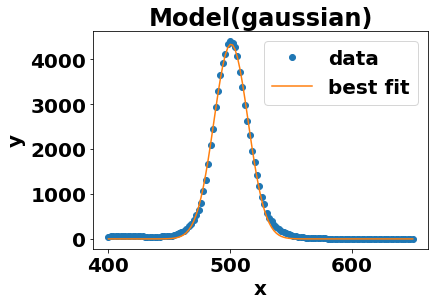

/usr/local/lib/python3.8/dist-packages/lmfit/model.py:994: UserWarning: The keyword argument negative does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


{'amplitude': 86701.5319927138, 'center': 499.225808846867, 'sigma': 14.080084007279467, 'fwhm': 33.15606342202184, 'height': 2456.5839641875864}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 254317.875
    reduced chi-square = 2067.62500
    Akaike info crit   = 964.867350
    Bayesian info crit = 973.376196
    R-squared          = 0.99565547
[[Variables]]
    amplitude:  86701.5320 +/- 556.419007 (0.64%) (init = 112500)
    center:     499.225809 +/- 0.10433984 (0.02%) (init = 499)
    sigma:      14.0800840 +/- 0.10433984 (0.74%) (init = 15)
    fwhm:       33.1560634 +/- 0.24570153 (0.74%) == '2.3548200*sigma'
    height:     2456.58396 +/- 15.7654740 (0.64%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


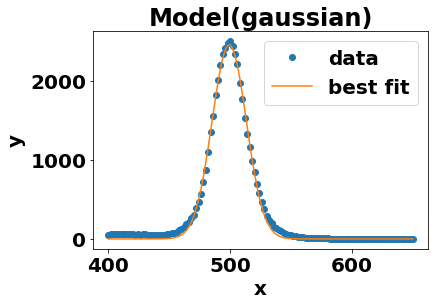

In [21]:


data = Readone
result_readone= np.zeros((data.shape[0],data.shape[1],4))
x = luminescence_wavelength  #np.arange(dat.shape[0])


 
fwhm=[]
center=[]
height=[]
fit_data=[]
for i in range (40):
  y=data[:,i]
  mod = GaussianModel()
  pars = mod.guess(y, x=x)
  result = mod.fit(y, pars, x=x,negative=False) 
  val= result.params.valuesdict()
  f= np.array(val['fwhm'])
  fwhm.append(f)
  c= np.array(val['center'])
  center.append(c)
  h=np.array(val['height'])
  height.append(h)

  print(result.params.valuesdict())
  para=result.fit_report()
  print(result.fit_report())
  
  result.plot_fit()
     
      
  plt.show()
  
  



### Bar plot for Read One

## Intensity Bar plot

In [22]:
intensity_bar= pd.DataFrame(height)
intensity_bar.rename(columns={intensity_bar.columns[0]: 'Height'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

intensity_bar['wells']=wells

print(intensity_bar)

          Height  wells
0   22790.709643  1:0.1
1   36602.635628  1:0.2
2   54188.246319  1:0.3
3   53170.761463  1:0.4
4   57862.815010  1:0.5
5   60823.503413  1:0.6
6   43780.194513  1:0.7
7   75264.689612  1:0.8
8   25617.088023  1:0.9
9    9533.327962    1:1
10  15765.391086  1:1.1
11  11103.445059  1:1.2
12   7501.178067  1:1.3
13  20548.397305  1:1.4
14   1302.250006  1:1.5
15   4669.836931  1:1.6
16    703.310629  1:1.7
17   6250.565955  1:1.8
18   1575.668255  1:1.9
19   1134.707525    1:2
20   1144.524240  1:0.1
21   8336.696280  1:0.2
22  15602.148770  1:0.3
23  35079.318775  1:0.4
24   1950.588435  1:0.5
25  55462.322535  1:0.6
26   5703.461193  1:0.7
27    616.391272  1:0.8
28  21302.330837  1:0.9
29   1375.018762    1:1
30  10587.330279  1:1.1
31  38289.902601  1:1.2
32  15211.164000  1:1.3
33  25337.112970  1:1.4
34   2654.321006  1:1.5
35  11316.969976  1:1.6
36   2607.317408  1:1.7
37   8230.858490  1:1.8
38   4338.912509  1:1.9
39   2456.583964    1:2


Text(0.5, 1.0, '$300$ $ul$ $PbBr_2$ $CsPbBr_2$ $(Toluene)$')

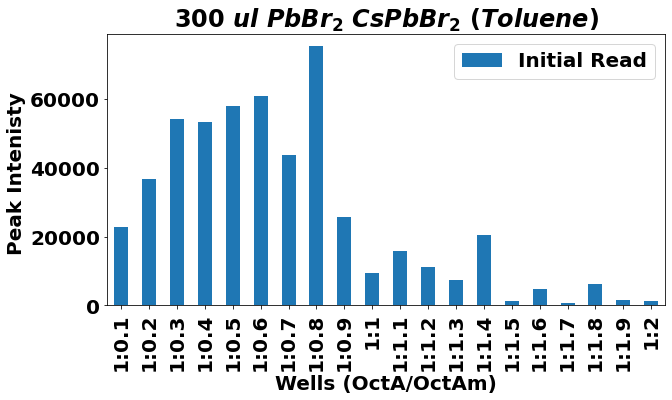

In [23]:

plotdata= intensity_bar[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);


ax.set_xlabel("Wells (OctA/OctAm)")
ax.set_ylabel("Peak Intenisty ")
ax.set_xticklabels(intensity_bar['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])
#ax.invert_xaxis()
ax.set_title('$300$ $ul$ $PbBr_2$ $CsPbBr_2$ $(Toluene)$')

##FWHM Bar Plot

In [24]:
fwhm_bar= pd.DataFrame(fwhm)
fwhm_bar.rename(columns={fwhm_bar.columns[0]: 'fwhm'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

fwhm_bar['wells']=wells

print(fwhm_bar)

         fwhm  wells
0   25.358154  1:0.1
1   26.692065  1:0.2
2   30.339031  1:0.3
3   27.894303  1:0.4
4   28.514462  1:0.5
5   27.851506  1:0.6
6   33.518189  1:0.7
7   28.294370  1:0.8
8   39.478617  1:0.9
9   32.868347    1:1
10  36.799540  1:1.1
11  32.730611  1:1.2
12  31.391688  1:1.3
13  28.365172  1:1.4
14  35.176525  1:1.5
15  30.920441  1:1.6
16  38.169985  1:1.7
17  45.201975  1:1.8
18  35.824428  1:1.9
19  32.163601    1:2
20  29.109954  1:0.1
21  26.132218  1:0.2
22  25.173283  1:0.3
23  25.542033  1:0.4
24  31.850517  1:0.5
25  25.142120  1:0.6
26  26.613494  1:0.7
27  34.633514  1:0.8
28  25.232606  1:0.9
29  33.823255    1:1
30  30.907937  1:1.1
31  26.342244  1:1.2
32  32.951343  1:1.3
33  26.580219  1:1.4
34  33.936891  1:1.5
35  33.183191  1:1.6
36  33.657225  1:1.7
37  33.252322  1:1.8
38  32.989224  1:1.9
39  33.156063    1:2


Text(0.5, 1.0, '300 ul PbBr2')

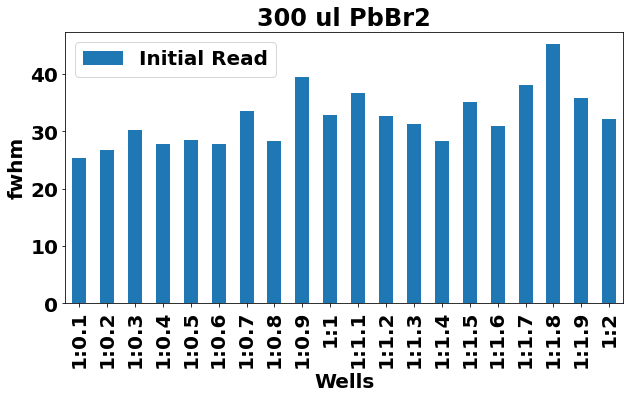

In [25]:

plotdata= fwhm_bar[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);


ax.set_xlabel("Wells")
ax.set_ylabel("fwhm")
ax.set_xticklabels(fwhm_bar['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('300 ul PbBr2')

##Center Bar Plot for Read Initial

In [26]:
center_bar= pd.DataFrame(center)
center_bar.rename(columns={center_bar.columns[0]: 'center'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

center_bar['wells']=wells

print(center_bar)

        center  wells
0   521.674353  1:0.1
1   522.826225  1:0.2
2   517.315655  1:0.3
3   518.853033  1:0.4
4   519.495909  1:0.5
5   520.394296  1:0.6
6   514.205878  1:0.7
7   519.530204  1:0.8
8   509.066804  1:0.9
9   512.497974    1:1
10  510.462068  1:1.1
11  512.099467  1:1.2
12  513.538652  1:1.3
13  519.065899  1:1.4
14  508.274417  1:1.5
15  513.772368  1:1.6
16  501.963382  1:1.7
17  509.211562  1:1.8
18  507.366750  1:1.9
19  509.207343    1:2
20  521.648118  1:0.1
21  503.899903  1:0.2
22  495.683774  1:0.3
23  508.558476  1:0.4
24  500.922263  1:0.5
25  514.710909  1:0.6
26  502.637313  1:0.7
27  500.047799  1:0.8
28  496.043505  1:0.9
29  502.135563    1:1
30  494.627401  1:1.1
31  513.491117  1:1.2
32  506.691232  1:1.3
33  503.275613  1:1.4
34  502.632695  1:1.5
35  506.298641  1:1.6
36  500.292681  1:1.7
37  506.633225  1:1.8
38  500.722271  1:1.9
39  499.225809    1:2


Text(0.5, 1.0, '300 ul PbBr2')

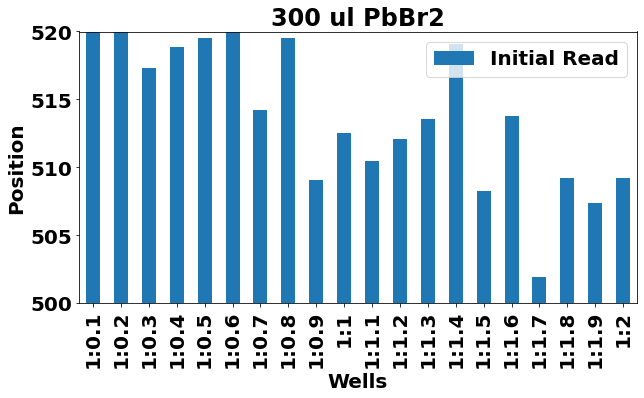

In [27]:

plotdata= center_bar[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);

plt.ylim([500, 520])
ax.set_xlabel("Wells")
ax.set_ylabel("Position")
ax.set_xticklabels(center_bar['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])
#ax.invert_xaxis()
ax.set_title('300 ul PbBr2')

## Gaussian Fit for Final Read

In [28]:
d['Read 42']=d['Read 42'].dropna(axis=1)
d['Read 42']=d['Read 42'].reset_index(drop=True)

d['Read 42'] = d['Read 42'].drop(['Wavelength'], axis = 1)

In [29]:
Readfinal= np.array(d['Read 42'])

{'amplitude': 16807.89438201349, 'center': 522.2290631362324, 'sigma': 11.166804087709629, 'fwhm': 26.295813601820388, 'height': 600.4744052327015}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 106211.199
    reduced chi-square = 863.505680
    Akaike info crit   = 854.849768
    Bayesian info crit = 863.358614
    R-squared          = 0.96157814
[[Variables]]
    amplitude:  16807.8944 +/- 320.232433 (1.91%) (init = 22032)
    center:     522.229063 +/- 0.24567187 (0.05%) (init = 522)
    sigma:      11.1668041 +/- 0.24567184 (2.20%) (init = 12)
    fwhm:       26.2958136 +/- 0.57851296 (2.20%) == '2.3548200*sigma'
    height:     600.474405 +/- 11.4406289 (1.91%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


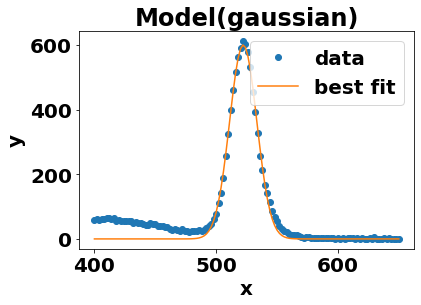

{'amplitude': 268292.7388678825, 'center': 523.7628637089854, 'sigma': 10.800870367892289, 'fwhm': 25.43410555972012, 'height': 9909.69418866743}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1930525.91
    reduced chi-square = 15695.3326
    Akaike info crit   = 1220.26466
    Bayesian info crit = 1228.77351
    R-squared          = 0.99755269
[[Variables]]
    amplitude:  268292.739 +/- 1342.69536 (0.50%) (init = 331551)
    center:     523.762864 +/- 0.06241607 (0.01%) (init = 523)
    sigma:      10.8008704 +/- 0.06241607 (0.58%) (init = 11)
    fwhm:       25.4341056 +/- 0.14697862 (0.58%) == '2.3548200*sigma'
    height:     9909.69419 +/- 49.5939441 (0.50%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


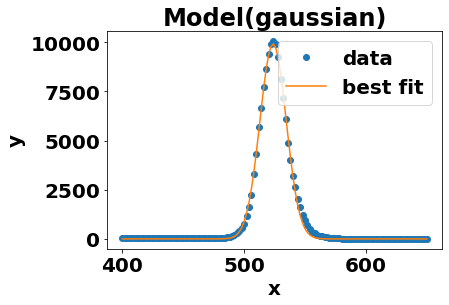

{'amplitude': 307011.8866252445, 'center': 523.3673331047643, 'sigma': 12.084691257816571, 'fwhm': 28.45727266773162, 'height': 10135.139207498765}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 10511248.4
    reduced chi-square = 85457.3043
    Akaike info crit   = 1433.79100
    Bayesian info crit = 1442.29985
    R-squared          = 0.98816948
[[Variables]]
    amplitude:  307011.887 +/- 3314.01354 (1.08%) (init = 376344)
    center:     523.367333 +/- 0.15062700 (0.03%) (init = 524)
    sigma:      12.0846913 +/- 0.15062700 (1.25%) (init = 12)
    fwhm:       28.4572727 +/- 0.35469948 (1.25%) == '2.3548200*sigma'
    height:     10135.1392 +/- 109.402696 (1.08%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


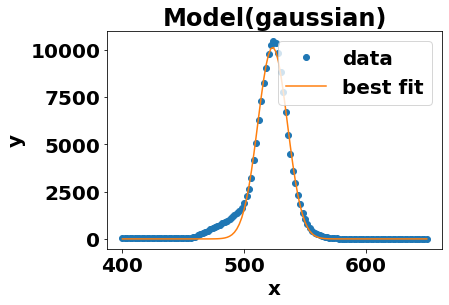

{'amplitude': 478678.2266861592, 'center': 522.0735859364243, 'sigma': 10.866935698854151, 'fwhm': 25.589677522375734, 'height': 17573.030521772}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 5069881.05
    reduced chi-square = 41218.5451
    Akaike info crit   = 1341.92080
    Bayesian info crit = 1350.42964
    R-squared          = 0.99796470
[[Variables]]
    amplitude:  478678.227 +/- 2182.54475 (0.46%) (init = 638820)
    center:     522.073586 +/- 0.05721319 (0.01%) (init = 522)
    sigma:      10.8669357 +/- 0.05721319 (0.53%) (init = 12)
    fwhm:       25.5896775 +/- 0.13472676 (0.53%) == '2.3548200*sigma'
    height:     17573.0305 +/- 80.1246733 (0.46%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


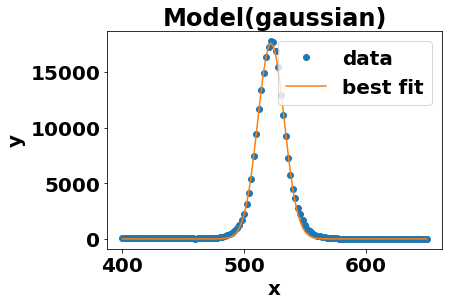

{'amplitude': 518885.1179835765, 'center': 522.832379088323, 'sigma': 11.094901439957633, 'fwhm': 26.126495808841035, 'height': 18657.68916690168}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 7579306.13
    reduced chi-square = 61620.3751
    Akaike info crit   = 1392.58594
    Bayesian info crit = 1401.09478
    R-squared          = 0.99733805
[[Variables]]
    amplitude:  518885.118 +/- 2696.41454 (0.52%) (init = 624261)
    center:     522.832379 +/- 0.06657450 (0.01%) (init = 523)
    sigma:      11.0949014 +/- 0.06657450 (0.60%) (init = 11)
    fwhm:       26.1264958 +/- 0.15677097 (0.60%) == '2.3548200*sigma'
    height:     18657.6892 +/- 96.9556402 (0.52%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


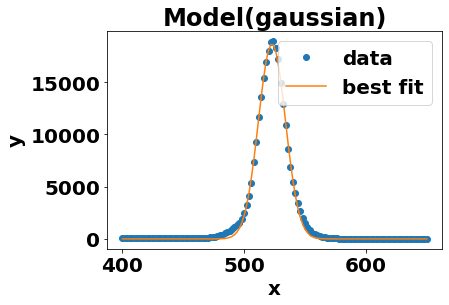

{'amplitude': 506198.02833515854, 'center': 522.6227033207321, 'sigma': 10.929873683663265, 'fwhm': 25.737885147763933, 'height': 18476.31651785107}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 5474174.92
    reduced chi-square = 44505.4872
    Akaike info crit   = 1351.58805
    Bayesian info crit = 1360.09689
    R-squared          = 0.99802380
[[Variables]]
    amplitude:  506198.028 +/- 2274.45629 (0.45%) (init = 671472)
    center:     522.622703 +/- 0.05670767 (0.01%) (init = 522)
    sigma:      10.9298737 +/- 0.05670767 (0.52%) (init = 12)
    fwhm:       25.7378851 +/- 0.13353636 (0.52%) == '2.3548200*sigma'
    height:     18476.3165 +/- 83.0180718 (0.45%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


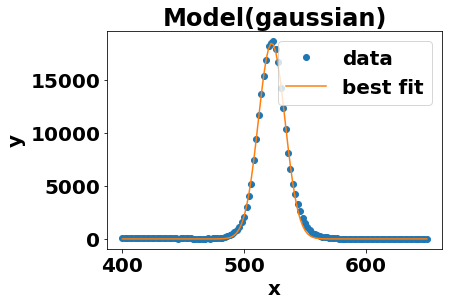

{'amplitude': 263099.5692743581, 'center': 522.2182164147216, 'sigma': 11.515731123407862, 'fwhm': 27.117473964023304, 'height': 9114.622959715334}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 4554494.12
    reduced chi-square = 37028.4075
    Akaike info crit   = 1328.41323
    Bayesian info crit = 1336.92208
    R-squared          = 0.99343367
[[Variables]]
    amplitude:  263099.569 +/- 2129.49949 (0.81%) (init = 334908)
    center:     522.218216 +/- 0.10762656 (0.02%) (init = 522)
    sigma:      11.5157311 +/- 0.10762656 (0.93%) (init = 12)
    fwhm:       27.1174740 +/- 0.25344117 (0.93%) == '2.3548200*sigma'
    height:     9114.62296 +/- 73.7729030 (0.81%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


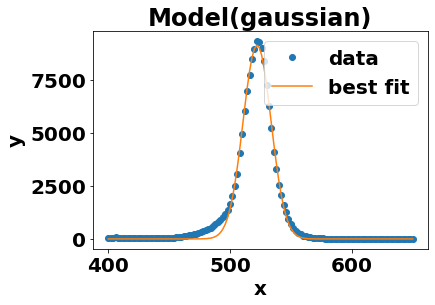

{'amplitude': 423429.2576611748, 'center': 521.544064260137, 'sigma': 10.655636215140126, 'fwhm': 25.092105272136273, 'height': 15853.00384960827}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 3804176.70
    reduced chi-square = 30928.2659
    Akaike info crit   = 1305.73136
    Bayesian info crit = 1314.24020
    R-squared          = 0.99809327
[[Variables]]
    amplitude:  423429.258 +/- 1872.10880 (0.44%) (init = 523611)
    center:     521.544064 +/- 0.05440007 (0.01%) (init = 521)
    sigma:      10.6556362 +/- 0.05440007 (0.51%) (init = 11)
    fwhm:       25.0921053 +/- 0.12810238 (0.51%) == '2.3548200*sigma'
    height:     15853.0038 +/- 70.0909785 (0.44%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


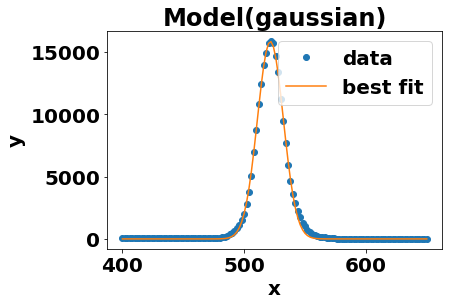

{'amplitude': 145019.579770353, 'center': 517.8831603952483, 'sigma': 14.322769300300921, 'fwhm': 33.72754360373462, 'height': 4039.333699063531}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 126
    # variables        = 3
    chi-square         = 7533314.80
    reduced chi-square = 61246.4618
    Akaike info crit   = 1391.81904
    Bayesian info crit = 1400.32789
    R-squared          = 0.95334841
[[Variables]]
    amplitude:  145019.580 +/- 3054.31655 (2.11%) (init = 170274)
    center:     517.883160 +/- 0.34832184 (0.07%) (init = 519)
    sigma:      14.3227693 +/- 0.34832187 (2.43%) (init = 13)
    fwhm:       33.7275436 +/- 0.82023530 (2.43%) == '2.3548200*sigma'
    height:     4039.33370 +/- 85.0736587 (2.11%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


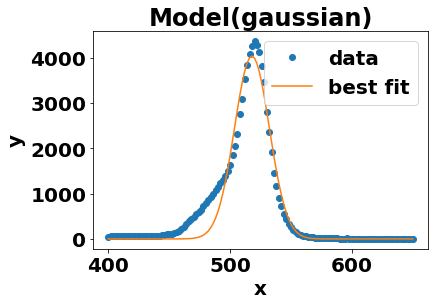

{'amplitude': 39227.761846302, 'center': 518.1487292052752, 'sigma': 13.061836160821079, 'fwhm': 30.758273028224693, 'height': 1198.1174271467985}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 594580.574
    reduced chi-square = 4833.98841
    Akaike info crit   = 1071.87553
    Bayesian info crit = 1080.38438
    R-squared          = 0.95276614
[[Variables]]
    amplitude:  39227.7618 +/- 819.434170 (2.09%) (init = 48321)
    center:     518.148729 +/- 0.31505777 (0.06%) (init = 519)
    sigma:      13.0618362 +/- 0.31505780 (2.41%) (init = 13)
    fwhm:       30.7582730 +/- 0.74190440 (2.41%) == '2.3548200*sigma'
    height:     1198.11743 +/- 25.0274911 (2.09%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


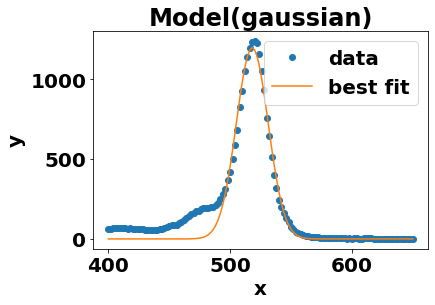

{'amplitude': 68319.68164143208, 'center': 522.1630379902602, 'sigma': 12.079404674106991, 'fwhm': 28.444823714680627, 'height': 2256.370381209673}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 791431.366
    reduced chi-square = 6434.40135
    Akaike info crit   = 1107.90988
    Bayesian info crit = 1116.41873
    R-squared          = 0.98172905
[[Variables]]
    amplitude:  68319.6816 +/- 909.157290 (1.33%) (init = 84276)
    center:     522.163038 +/- 0.18561248 (0.04%) (init = 522)
    sigma:      12.0794047 +/- 0.18561249 (1.54%) (init = 12)
    fwhm:       28.4448237 +/- 0.43708400 (1.54%) == '2.3548200*sigma'
    height:     2256.37038 +/- 30.0263803 (1.33%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


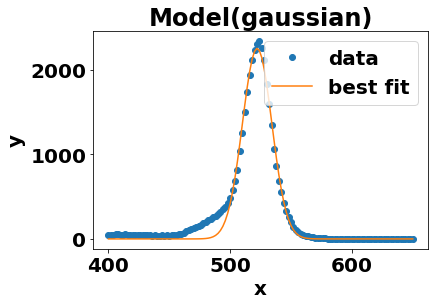

{'amplitude': 92499.45110340642, 'center': 517.1702706722081, 'sigma': 13.068287883234255, 'fwhm': 30.77346567319769, 'height': 2823.777996142344}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 126
    # variables        = 3
    chi-square         = 1117251.17
    reduced chi-square = 9083.34281
    Akaike info crit   = 1151.35260
    Bayesian info crit = 1159.86145
    R-squared          = 0.98454097
[[Variables]]
    amplitude:  92499.4511 +/- 1123.56158 (1.21%) (init = 113334)
    center:     517.170271 +/- 0.18329363 (0.04%) (init = 517)
    sigma:      13.0682879 +/- 0.18329362 (1.40%) (init = 13)
    fwhm:       30.7734657 +/- 0.43162349 (1.40%) == '2.3548200*sigma'
    height:     2823.77800 +/- 34.2996204 (1.21%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


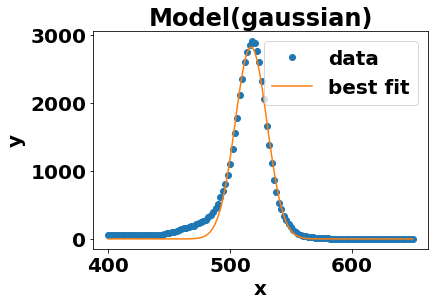

{'amplitude': 948812.2776416586, 'center': 515.9637910876083, 'sigma': 12.381255159851326, 'fwhm': 29.155627275521102, 'height': 30572.13080770941}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 32078611.6
    reduced chi-square = 260801.720
    Akaike info crit   = 1574.37469
    Bayesian info crit = 1582.88353
    R-squared          = 0.99615161
[[Variables]]
    amplitude:  948812.278 +/- 5860.05337 (0.62%) (init = 1202097)
    center:     515.963791 +/- 0.08829909 (0.02%) (init = 515)
    sigma:      12.3812552 +/- 0.08829909 (0.71%) (init = 13)
    fwhm:       29.1556273 +/- 0.20792846 (0.71%) == '2.3548200*sigma'
    height:     30572.1308 +/- 188.819825 (0.62%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


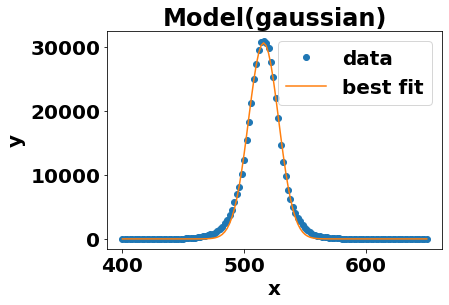

{'amplitude': 1721448.3178237053, 'center': 527.046272478656, 'sigma': 12.146184493507713, 'fwhm': 28.602078169001835, 'height': 56541.093345881665}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 31256420.0
    reduced chi-square = 254117.235
    Akaike info crit   = 1571.10313
    Bayesian info crit = 1579.61198
    R-squared          = 0.99889984
[[Variables]]
    amplitude:  1721448.32 +/- 5729.28339 (0.33%) (init = 2228148)
    center:     527.046272 +/- 0.04667838 (0.01%) (init = 527)
    sigma:      12.1461845 +/- 0.04667838 (0.38%) (init = 13)
    fwhm:       28.6020782 +/- 0.10991918 (0.38%) == '2.3548200*sigma'
    height:     56541.0933 +/- 188.178787 (0.33%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


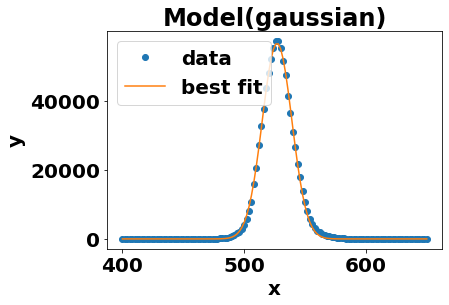

{'amplitude': 252887.7934156679, 'center': 515.4615758379398, 'sigma': 12.202214127507531, 'fwhm': 28.734017871737286, 'height': 8267.97799915179}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 2764880.72
    reduced chi-square = 22478.7050
    Akaike info crit   = 1265.52449
    Bayesian info crit = 1274.03334
    R-squared          = 0.99534839
[[Variables]]
    amplitude:  252887.793 +/- 1707.92504 (0.68%) (init = 326586)
    center:     515.461576 +/- 0.09515896 (0.02%) (init = 515)
    sigma:      12.2022141 +/- 0.09515896 (0.78%) (init = 13)
    fwhm:       28.7340179 +/- 0.22408223 (0.78%) == '2.3548200*sigma'
    height:     8267.97800 +/- 55.8394005 (0.68%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


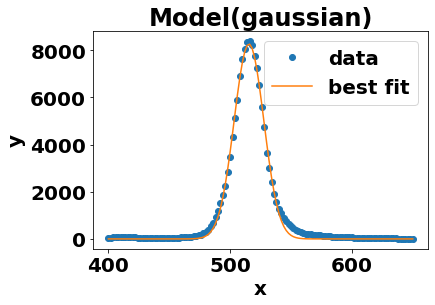

{'amplitude': 724567.8450286506, 'center': 516.8243914166189, 'sigma': 11.97228141538487, 'fwhm': 28.1925677225766, 'height': 24144.167061619395}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 13131670.4
    reduced chi-square = 106761.548
    Akaike info crit   = 1461.83620
    Bayesian info crit = 1470.34505
    R-squared          = 0.99741213
[[Variables]]
    amplitude:  724567.845 +/- 3686.88270 (0.51%) (init = 948363)
    center:     516.824391 +/- 0.07034397 (0.01%) (init = 517)
    sigma:      11.9722814 +/- 0.07034397 (0.59%) (init = 13)
    fwhm:       28.1925677 +/- 0.16564740 (0.59%) == '2.3548200*sigma'
    height:     24144.1671 +/- 122.854967 (0.51%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


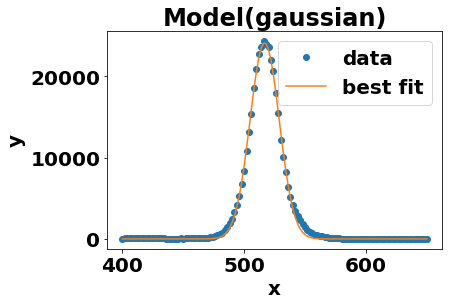

{'amplitude': 119802.42532588997, 'center': 510.6381044036767, 'sigma': 13.999379245310056, 'fwhm': 32.96601823444103, 'height': 3414.026741300004}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 1054834.19
    reduced chi-square = 8575.88773
    Akaike info crit   = 1144.10914
    Bayesian info crit = 1152.61799
    R-squared          = 0.99036949
[[Variables]]
    amplitude:  119802.425 +/- 1129.94739 (0.94%) (init = 158220)
    center:     510.638104 +/- 0.15246563 (0.03%) (init = 511)
    sigma:      13.9993792 +/- 0.15246563 (1.09%) (init = 15)
    fwhm:       32.9660182 +/- 0.35902912 (1.09%) == '2.3548200*sigma'
    height:     3414.02674 +/- 32.2003307 (0.94%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


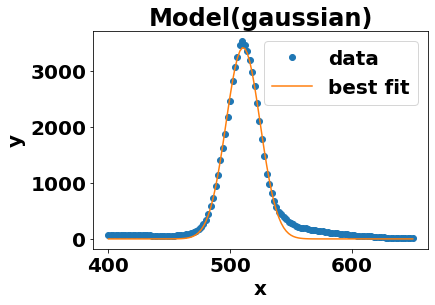

{'amplitude': 1443448.2859928804, 'center': 513.2995314328108, 'sigma': 16.22491544697098, 'fwhm': 38.2067553928362, 'height': 35491.86934299637}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 2.8374e+08
    reduced chi-square = 2306853.33
    Akaike info crit   = 1849.03947
    Bayesian info crit = 1857.54832
    R-squared          = 0.97964323
[[Variables]]
    amplitude:  1443448.29 +/- 19950.8681 (1.38%) (init = 1797024)
    center:     513.299531 +/- 0.25894639 (0.05%) (init = 514)
    sigma:      16.2249154 +/- 0.25894641 (1.60%) (init = 16)
    fwhm:       38.2067554 +/- 0.60977219 (1.60%) == '2.3548200*sigma'
    height:     35491.8693 +/- 490.555086 (1.38%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


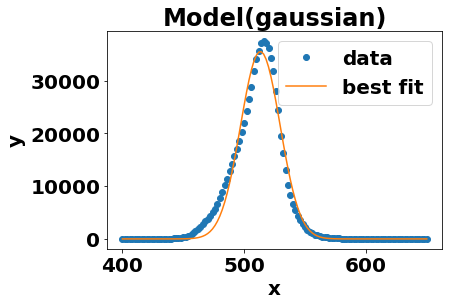

{'amplitude': 293287.91396998055, 'center': 515.0909652776671, 'sigma': 12.54839919679364, 'fwhm': 29.5492213965936, 'height': 9324.293332274861}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 2662367.05
    reduced chi-square = 21645.2606
    Akaike info crit   = 1260.76397
    Bayesian info crit = 1269.27282
    R-squared          = 0.99659013
[[Variables]]
    amplitude:  293287.914 +/- 1699.56963 (0.58%) (init = 366873)
    center:     515.090965 +/- 0.08396587 (0.02%) (init = 515)
    sigma:      12.5483992 +/- 0.08396587 (0.67%) (init = 13)
    fwhm:       29.5492214 +/- 0.19772450 (0.67%) == '2.3548200*sigma'
    height:     9324.29333 +/- 54.0332274 (0.58%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


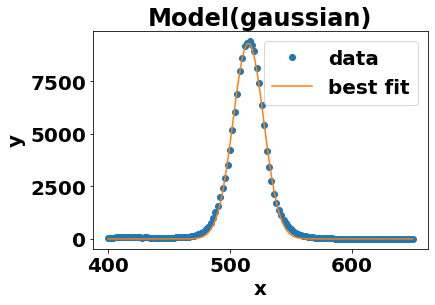

{'amplitude': 267430.4495676156, 'center': 514.1578896187663, 'sigma': 11.923588751955846, 'fwhm': 28.077905264880666, 'height': 8947.752296726785}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2861890.43
    reduced chi-square = 23267.4019
    Akaike info crit   = 1269.86959
    Bayesian info crit = 1278.37844
    R-squared          = 0.99581930
[[Variables]]
    amplitude:  267430.450 +/- 1717.67451 (0.64%) (init = 324936)
    center:     514.157890 +/- 0.08843144 (0.02%) (init = 514)
    sigma:      11.9235888 +/- 0.08843144 (0.74%) (init = 12)
    fwhm:       28.0779053 +/- 0.20824013 (0.74%) == '2.3548200*sigma'
    height:     8947.75230 +/- 57.4703962 (0.64%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


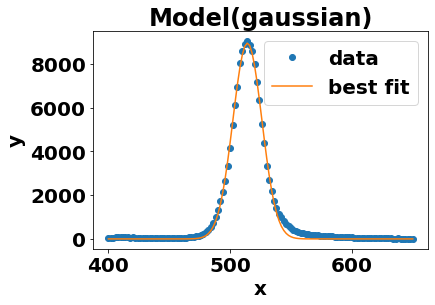

{'amplitude': 26092.41990179176, 'center': 515.9120366697537, 'sigma': 10.91250807320854, 'fwhm': 25.696992260952936, 'height': 953.893453123098}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 86682.7311
    reduced chi-square = 704.737652
    Akaike info crit   = 829.249735
    Bayesian info crit = 837.758581
    R-squared          = 0.98773868
[[Variables]]
    amplitude:  26092.4199 +/- 285.982568 (1.10%) (init = 34560)
    center:     515.912037 +/- 0.13810824 (0.03%) (init = 516)
    sigma:      10.9125081 +/- 0.13810824 (1.27%) (init = 12)
    fwhm:       25.6969923 +/- 0.32522004 (1.27%) == '2.3548200*sigma'
    height:     953.893453 +/- 10.4550317 (1.10%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


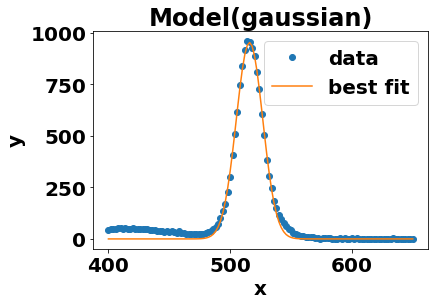

{'amplitude': 46019.51480730223, 'center': 504.5638871387488, 'sigma': 10.959512875564409, 'fwhm': 25.807680109636582, 'height': 1675.1776552991844}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 146359.370
    reduced chi-square = 1189.91358
    Akaike info crit   = 895.249840
    Bayesian info crit = 903.758685
    R-squared          = 0.99344422
[[Variables]]
    amplitude:  46019.5148 +/- 372.406075 (0.81%) (init = 61596)
    center:     504.563887 +/- 0.10240842 (0.02%) (init = 504)
    sigma:      10.9595129 +/- 0.10240842 (0.93%) (init = 12)
    fwhm:       25.8076801 +/- 0.24115340 (0.93%) == '2.3548200*sigma'
    height:     1675.17766 +/- 13.5561330 (0.81%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


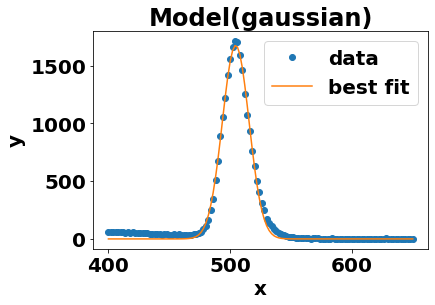

{'amplitude': 61925.69237582429, 'center': 488.1246856474994, 'sigma': 10.9203106893648, 'fwhm': 25.71536601753002, 'height': 2262.2779560258837}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 219375.757
    reduced chi-square = 1783.54274
    Akaike info crit   = 946.244686
    Bayesian info crit = 954.753532
    R-squared          = 0.99463425
[[Variables]]
    amplitude:  61925.6924 +/- 455.116805 (0.73%) (init = 75636)
    center:     488.124686 +/- 0.09267378 (0.02%) (init = 489)
    sigma:      10.9203107 +/- 0.09267378 (0.85%) (init = 11)
    fwhm:       25.7153660 +/- 0.21823007 (0.85%) == '2.3548200*sigma'
    height:     2262.27796 +/- 16.6264029 (0.73%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


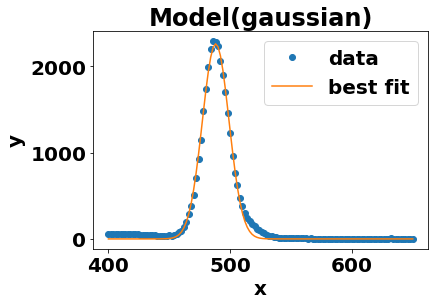

{'amplitude': 206649.90898550017, 'center': 500.15653571842955, 'sigma': 10.287421146270368, 'fwhm': 24.22502506366039, 'height': 8013.805288350099}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1365297.93
    reduced chi-square = 11099.9831
    Akaike info crit   = 1176.61577
    Bayesian info crit = 1185.12461
    R-squared          = 0.99724485
[[Variables]]
    amplitude:  206649.909 +/- 1101.99150 (0.53%) (init = 266310)
    center:     500.156536 +/- 0.06334606 (0.01%) (init = 499)
    sigma:      10.2874211 +/- 0.06334606 (0.62%) (init = 11)
    fwhm:       24.2250251 +/- 0.14916858 (0.62%) == '2.3548200*sigma'
    height:     8013.80529 +/- 42.7348605 (0.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


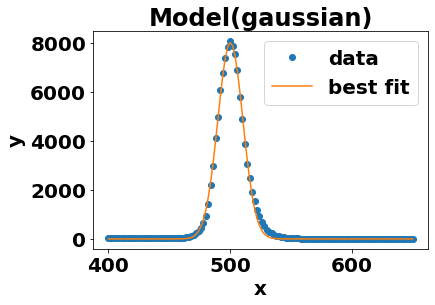

{'amplitude': 18506.069228670185, 'center': 333.3777772750384, 'sigma': 112.6669094184349, 'fwhm': 265.3102916367189, 'height': 65.52814717430161}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 126
    # variables        = 3
    chi-square         = 6857.18194
    reduced chi-square = 55.7494467
    Akaike info crit   = 509.593012
    Bayesian info crit = 518.101857
    R-squared          = 0.84651133
[[Variables]]
    amplitude:  18506.0692 +/- 6786.60503 (36.67%) (init = 10440)
    center:     333.377777 +/- 43.3111286 (12.99%) (init = 452.9767)
    sigma:      112.666909 +/- 17.8954150 (15.88%) (init = 60)
    fwhm:       265.310292 +/- 42.1404811 (15.88%) == '2.3548200*sigma'
    height:     65.5281472 +/- 14.0431577 (21.43%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = -0.998
    C(center, sigma)     = -0.980
    C(

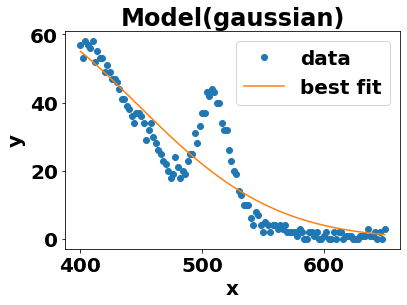

{'amplitude': 346875.37230056175, 'center': 509.79380466164804, 'sigma': 10.461841811587982, 'fwhm': 24.635754334763615, 'height': 13227.427954957531}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1691814.07
    reduced chi-square = 13754.5860
    Akaike info crit   = 1203.63378
    Bayesian info crit = 1212.14263
    R-squared          = 0.99876657
[[Variables]]
    amplitude:  346875.372 +/- 1237.06124 (0.36%) (init = 440880)
    center:     509.793805 +/- 0.04308197 (0.01%) (init = 509)
    sigma:      10.4618418 +/- 0.04308197 (0.41%) (init = 11)
    fwhm:       24.6357543 +/- 0.10145027 (0.41%) == '2.3548200*sigma'
    height:     13227.4280 +/- 47.1729796 (0.36%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


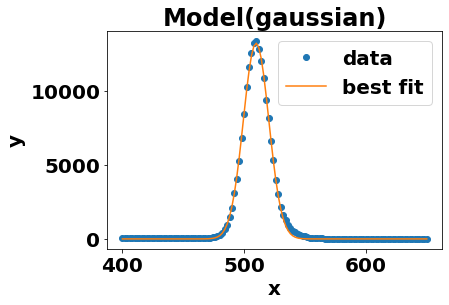

{'amplitude': 13031.124205339274, 'center': 413.5703266058304, 'sigma': 89.5503250598756, 'fwhm': 210.87489645749628, 'height': 58.05301832894256}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 126
    # variables        = 3
    chi-square         = 27598.6403
    reduced chi-square = 224.379189
    Akaike info crit   = 685.044225
    Bayesian info crit = 693.553070
    R-squared          = 0.68061377
[[Variables]]
    amplitude:  13031.1242 +/- 2254.83856 (17.30%) (init = 14880)
    center:     413.570327 +/- 18.0271446 (4.36%) (init = 458.3043)
    sigma:      89.5503251 +/- 12.2956871 (13.73%) (init = 62)
    fwhm:       210.874896 +/- 28.9541298 (13.73%) == '2.3548200*sigma'
    height:     58.0530183 +/- 3.49982129 (6.03%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = -0.958
    C(amplitude, sigma)  = 0.950
    C(cen

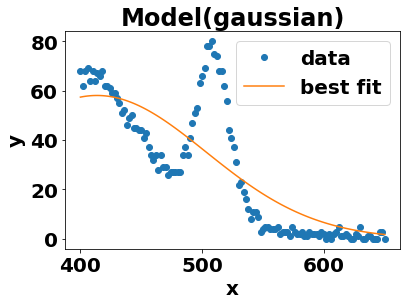

{'amplitude': 18187.99432957841, 'center': 335.9230055165706, 'sigma': 103.88161380734797, 'fwhm': 244.62250182581917, 'height': 69.84835934186965}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 126
    # variables        = 3
    chi-square         = 3231.91396
    reduced chi-square = 26.2757232
    Akaike info crit   = 414.813034
    Bayesian info crit = 423.321880
    R-squared          = 0.92715300
[[Variables]]
    amplitude:  18187.9943 +/- 4687.56454 (25.77%) (init = 10089)
    center:     335.923006 +/- 27.9182651 (8.31%) (init = 444.5128)
    sigma:      103.881614 +/- 11.3347789 (10.91%) (init = 57)
    fwhm:       244.622502 +/- 26.6913640 (10.91%) == '2.3548200*sigma'
    height:     69.8483593 +/- 10.6850858 (15.30%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = -0.998
    C(center, sigma)     = -0.981
    C(

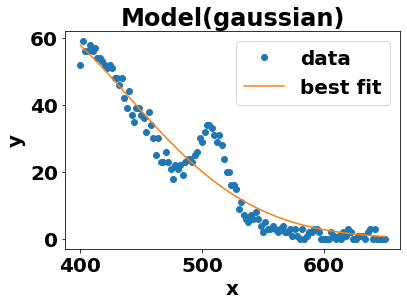

{'amplitude': 94660.61245807732, 'center': 489.66084482635534, 'sigma': 10.65736439211759, 'fwhm': 25.096174817846343, 'height': 3543.4767043684046}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 313445.012
    reduced chi-square = 2548.33343
    Akaike info crit   = 991.206262
    Bayesian info crit = 999.715108
    R-squared          = 0.99682918
[[Variables]]
    amplitude:  94660.6125 +/- 537.423516 (0.57%) (init = 117975)
    center:     489.660845 +/- 0.06986619 (0.01%) (init = 489)
    sigma:      10.6573644 +/- 0.06986619 (0.66%) (init = 11)
    fwhm:       25.0961748 +/- 0.16452231 (0.66%) == '2.3548200*sigma'
    height:     3543.47670 +/- 20.1176519 (0.57%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


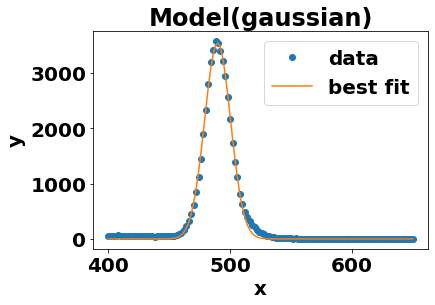

{'amplitude': 13849.376327505834, 'center': 397.75652460300967, 'sigma': 93.35645163000622, 'fwhm': 219.83763942737127, 'height': 59.182862557351925}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 126
    # variables        = 3
    chi-square         = 18060.4909
    reduced chi-square = 146.833259
    Akaike info crit   = 631.615212
    Bayesian info crit = 640.124058
    R-squared          = 0.75547126
[[Variables]]
    amplitude:  13849.3763 +/- 2655.91272 (19.18%) (init = 12993)
    center:     397.756525 +/- 20.6012987 (5.18%) (init = 457.0204)
    sigma:      93.3564516 +/- 12.3759295 (13.26%) (init = 61)
    fwhm:       219.837639 +/- 29.1430863 (13.26%) == '2.3548200*sigma'
    height:     59.1828626 +/- 4.41277566 (7.46%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = -0.979
    C(amplitude, sigma)  = 0.960
    C(

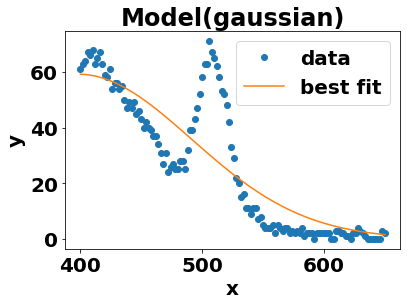

{'amplitude': 23596.881167330932, 'center': 493.07313017797725, 'sigma': 12.293560934376252, 'fwhm': 28.949123159487886, 'height': 765.7499804957304}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 145860.041
    reduced chi-square = 1185.85399
    Akaike info crit   = 894.819235
    Bayesian info crit = 903.328080
    R-squared          = 0.97061155
[[Variables]]
    amplitude:  23596.8812 +/- 393.748717 (1.67%) (init = 30810)
    center:     493.073130 +/- 0.23687172 (0.05%) (init = 493)
    sigma:      12.2935609 +/- 0.23687171 (1.93%) (init = 13)
    fwhm:       28.9491232 +/- 0.55779023 (1.93%) == '2.3548200*sigma'
    height:     765.749980 +/- 12.7776972 (1.67%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


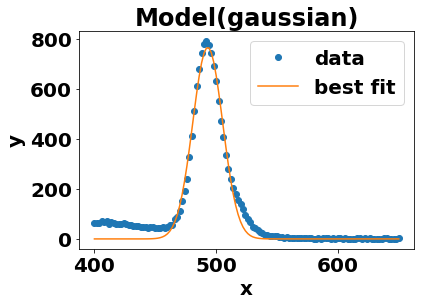

{'amplitude': 84966.11577488892, 'center': 511.8867820779081, 'sigma': 10.499825333396752, 'fwhm': 24.72519869158934, 'height': 3228.29919289093}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 196436.743
    reduced chi-square = 1597.04669
    Akaike info crit   = 932.328543
    Bayesian info crit = 940.837389
    R-squared          = 0.99756882
[[Variables]]
    amplitude:  84966.1158 +/- 422.292673 (0.50%) (init = 116604)
    center:     511.886782 +/- 0.06025871 (0.01%) (init = 512)
    sigma:      10.4998253 +/- 0.06025871 (0.57%) (init = 12)
    fwhm:       24.7251987 +/- 0.14189841 (0.57%) == '2.3548200*sigma'
    height:     3228.29919 +/- 16.0450826 (0.50%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


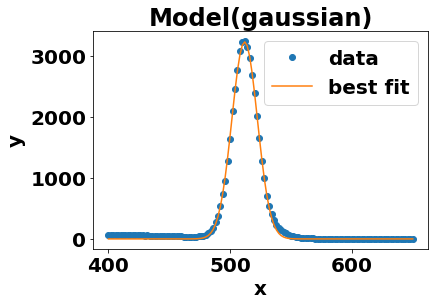

{'amplitude': 12987.395159801501, 'center': 426.32740291134934, 'sigma': 86.19448519434191, 'fwhm': 202.97249762534022, 'height': 60.11082129417012}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 126
    # variables        = 3
    chi-square         = 42523.1312
    reduced chi-square = 345.716514
    Akaike info crit   = 739.511717
    Bayesian info crit = 748.020563
    R-squared          = 0.60733415
[[Variables]]
    amplitude:  12987.3952 +/- 2059.53075 (15.86%) (init = 17670)
    center:     426.327403 +/- 15.9186359 (3.73%) (init = 457.3171)
    sigma:      86.1944852 +/- 12.1445699 (14.09%) (init = 62)
    fwhm:       202.972498 +/- 28.5982760 (14.09%) == '2.3548200*sigma'
    height:     60.1108213 +/- 3.32392316 (5.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.939
    C(amplitude, center) = -0.925
    C(c

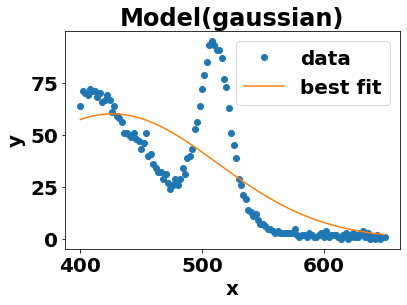

{'amplitude': 207721.31734972846, 'center': 502.3812888465633, 'sigma': 10.735006018947821, 'fwhm': 25.27900687353871, 'height': 7719.494516934874}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 1132436.73
    reduced chi-square = 9206.80271
    Akaike info crit   = 1153.05365
    Bayesian info crit = 1161.56249
    R-squared          = 0.99761898
[[Variables]]
    amplitude:  207721.317 +/- 1025.22415 (0.49%) (init = 281736)
    center:     502.381289 +/- 0.06118002 (0.01%) (init = 502)
    sigma:      10.7350060 +/- 0.06118002 (0.57%) (init = 12)
    fwhm:       25.2790069 +/- 0.14406793 (0.57%) == '2.3548200*sigma'
    height:     7719.49452 +/- 38.1001546 (0.49%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


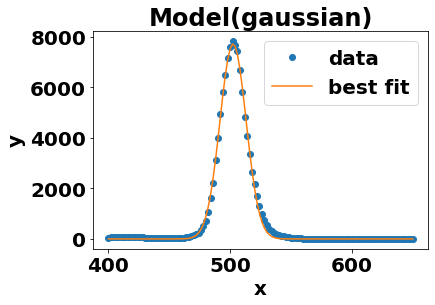

{'amplitude': 15188.75408659448, 'center': 399.1263958142638, 'sigma': 92.02217165144239, 'fwhm': 216.6956502482496, 'height': 65.84757108745568}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 126
    # variables        = 3
    chi-square         = 22964.2442
    reduced chi-square = 186.701173
    Akaike info crit   = 661.881884
    Bayesian info crit = 670.390730
    R-squared          = 0.75447808
[[Variables]]
    amplitude:  15188.7541 +/- 2880.02399 (18.96%) (init = 14091)
    center:     399.126396 +/- 20.1092562 (5.04%) (init = 456.9167)
    sigma:      92.0221717 +/- 12.1971445 (13.25%) (init = 61)
    fwhm:       216.695650 +/- 28.7220797 (13.25%) == '2.3548200*sigma'
    height:     65.8475711 +/- 4.80576532 (7.30%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = -0.978
    C(amplitude, sigma)  = 0.959
    C(cent

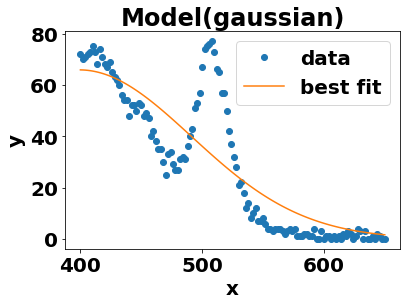

{'amplitude': 12935.143411898523, 'center': 450.642381860488, 'sigma': 75.64476767250643, 'fwhm': 178.1298118105716, 'height': 68.21854336196495}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 126
    # variables        = 3
    chi-square         = 80799.7957
    reduced chi-square = 656.908908
    Akaike info crit   = 820.394424
    Bayesian info crit = 828.903270
    R-squared          = 0.52294114
[[Variables]]
    amplitude:  12935.1434 +/- 1503.06165 (11.62%) (init = 23790)
    center:     450.642382 +/- 10.0164615 (2.22%) (init = 460)
    sigma:      75.6447677 +/- 9.65643824 (12.77%) (init = 61)
    fwhm:       178.129812 +/- 22.7391738 (12.77%) == '2.3548200*sigma'
    height:     68.2185434 +/- 4.03962997 (5.92%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.886
    C(amplitude, center) = -0.760
    C(center, s

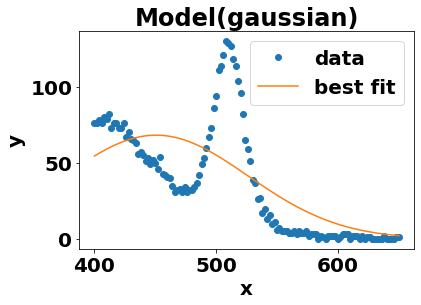

{'amplitude': 25618.854768475736, 'center': 315.97064663225194, 'sigma': 104.3222415590407, 'fwhm': 245.66010086806025, 'height': 97.96995052984424}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 126
    # variables        = 3
    chi-square         = 2637.52859
    reduced chi-square = 21.4433218
    Akaike info crit   = 389.205779
    Bayesian info crit = 397.714625
    R-squared          = 0.95652731
[[Variables]]
    amplitude:  25618.8548 +/- 6886.66597 (26.88%) (init = 6324)
    center:     315.970647 +/- 27.9724128 (8.85%) (init = 430.0645)
    sigma:      104.322242 +/- 10.1818948 (9.76%) (init = 31)
    fwhm:       245.660101 +/- 23.9765295 (9.76%) == '2.3548200*sigma'
    height:     97.9699505 +/- 17.0691284 (17.42%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = -0.998
    C(center, sigma)     = -0.986
    C(am

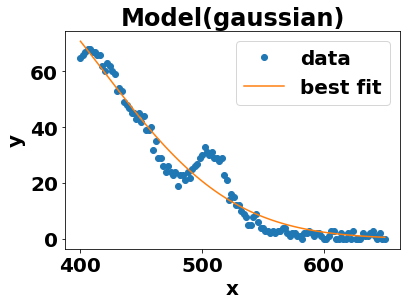

{'amplitude': 6011.026652982535, 'center': 508.4171912709799, 'sigma': 15.206128181645195, 'fwhm': 35.807694764701736, 'height': 157.70305035286782}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 130748.519
    reduced chi-square = 1062.99609
    Akaike info crit   = 881.038393
    Bayesian info crit = 889.547239
    R-squared          = 0.47868103
[[Variables]]
    amplitude:  6011.02665 +/- 414.591405 (6.90%) (init = 7650)
    center:     508.417191 +/- 1.21099322 (0.24%) (init = 509)
    sigma:      15.2061282 +/- 1.21099361 (7.96%) (init = 15)
    fwhm:       35.8076948 +/- 2.85167196 (7.96%) == '2.3548200*sigma'
    height:     157.703050 +/- 10.8767680 (6.90%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


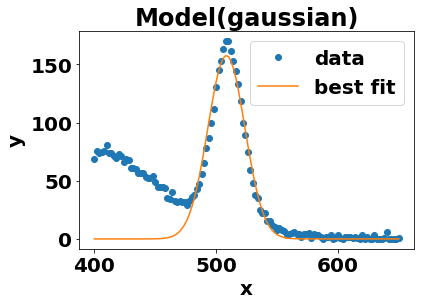

{'amplitude': 12284.214947089258, 'center': 455.548927422175, 'sigma': 70.44657720848862, 'fwhm': 165.88900894209317, 'height': 69.56609048843394}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 126
    # variables        = 3
    chi-square         = 76735.1178
    reduced chi-square = 623.862746
    Akaike info crit   = 813.890937
    Bayesian info crit = 822.399783
    R-squared          = 0.54529820
[[Variables]]
    amplitude:  12284.2149 +/- 1218.35957 (9.92%) (init = 22860)
    center:     455.548927 +/- 7.88982821 (1.73%) (init = 460)
    sigma:      70.4465772 +/- 8.04145512 (11.41%) (init = 60)
    fwhm:       165.889009 +/- 18.9361793 (11.41%) == '2.3548200*sigma'
    height:     69.5660905 +/- 4.06193482 (5.84%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.859
    C(amplitude, center) = -0.675
    C(center, s

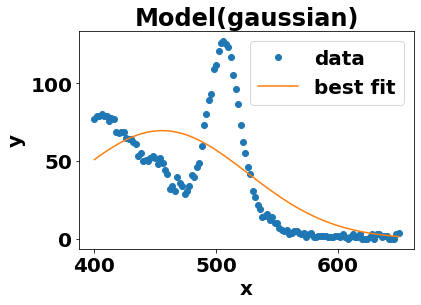

{'amplitude': 14897.715171859792, 'center': 407.7956559531361, 'sigma': 88.48399153652213, 'fwhm': 208.36387295003306, 'height': 67.1684069875341}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 126
    # variables        = 3
    chi-square         = 27980.4247
    reduced chi-square = 227.483127
    Akaike info crit   = 686.775293
    Bayesian info crit = 695.284139
    R-squared          = 0.73296745
[[Variables]]
    amplitude:  14897.7152 +/- 2544.55205 (17.08%) (init = 15120)
    center:     407.795656 +/- 17.5495920 (4.30%) (init = 456.2083)
    sigma:      88.4839915 +/- 11.4114851 (12.90%) (init = 60)
    fwhm:       208.363873 +/- 26.8719934 (12.90%) == '2.3548200*sigma'
    height:     67.1684070 +/- 4.13416274 (6.15%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = -0.967
    C(amplitude, sigma)  = 0.954
    C(cen

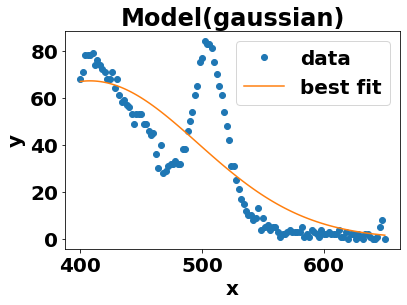

In [30]:

data = Readfinal
result_readfinal= np.zeros((data.shape[0],data.shape[1],4))
x = luminescence_wavelength  #np.arange(dat.shape[0])


 
fwhm2=[]
center2=[]
height2=[]
fit_data=[]
for i in range (40):
  y=data[:,i]
  mod = GaussianModel()
  pars = mod.guess(y, x=x)
  result = mod.fit(y, pars, x=x) 
  val= result.params.valuesdict()
  f= np.array(val['fwhm'])
  fwhm2.append(f)
  c= np.array(val['center'])
  center2.append(c)
  h=np.array(val['height'])
  height2.append(h)
  #values= np.array(result.params.valuesdict())
  #fit_data.append(values)
  print(result.params.valuesdict())
  para=result.fit_report()
  print(result.fit_report())
  
  result.plot_fit()
      
      
  plt.show()
  
  



##Intensity Bar Plot for Final Read

In [31]:
intensity_bar2= pd.DataFrame(height2)
intensity_bar2.rename(columns={intensity_bar2.columns[0]: 'Height'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

intensity_bar2['wells']=wells

print(intensity_bar2)

          Height  wells
0     600.474405  1:0.1
1    9909.694189  1:0.2
2   10135.139207  1:0.3
3   17573.030522  1:0.4
4   18657.689167  1:0.5
5   18476.316518  1:0.6
6    9114.622960  1:0.7
7   15853.003850  1:0.8
8    4039.333699  1:0.9
9    1198.117427    1:1
10   2256.370381  1:1.1
11   2823.777996  1:1.2
12  30572.130808  1:1.3
13  56541.093346  1:1.4
14   8267.977999  1:1.5
15  24144.167062  1:1.6
16   3414.026741  1:1.7
17  35491.869343  1:1.8
18   9324.293332  1:1.9
19   8947.752297    1:2
20    953.893453  1:0.1
21   1675.177655  1:0.2
22   2262.277956  1:0.3
23   8013.805288  1:0.4
24     65.528147  1:0.5
25  13227.427955  1:0.6
26     58.053018  1:0.7
27     69.848359  1:0.8
28   3543.476704  1:0.9
29     59.182863    1:1
30    765.749980  1:1.1
31   3228.299193  1:1.2
32     60.110821  1:1.3
33   7719.494517  1:1.4
34     65.847571  1:1.5
35     68.218543  1:1.6
36     97.969951  1:1.7
37    157.703050  1:1.8
38     69.566090  1:1.9
39     67.168407    1:2


Text(0.5, 1.0, '150 ul PbBr2')

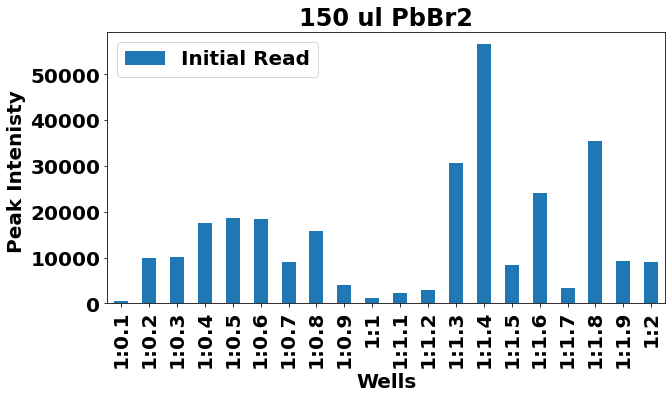

In [32]:

plotdata= intensity_bar2[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5), cmap=cmap);


ax.set_xlabel("Wells")
ax.set_ylabel("Peak Intenisty ")
ax.set_xticklabels(intensity_bar2['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('150 ul PbBr2')

## FWHM Bar Plot for Final Read

In [33]:
fwhm_bar2= pd.DataFrame(fwhm2)
fwhm_bar2.rename(columns={fwhm_bar2.columns[0]: 'fwhm'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

fwhm_bar2['wells']=wells

print(fwhm_bar2)

          fwhm  wells
0    26.295814  1:0.1
1    25.434106  1:0.2
2    28.457273  1:0.3
3    25.589678  1:0.4
4    26.126496  1:0.5
5    25.737885  1:0.6
6    27.117474  1:0.7
7    25.092105  1:0.8
8    33.727544  1:0.9
9    30.758273    1:1
10   28.444824  1:1.1
11   30.773466  1:1.2
12   29.155627  1:1.3
13   28.602078  1:1.4
14   28.734018  1:1.5
15   28.192568  1:1.6
16   32.966018  1:1.7
17   38.206755  1:1.8
18   29.549221  1:1.9
19   28.077905    1:2
20   25.696992  1:0.1
21   25.807680  1:0.2
22   25.715366  1:0.3
23   24.225025  1:0.4
24  265.310292  1:0.5
25   24.635754  1:0.6
26  210.874896  1:0.7
27  244.622502  1:0.8
28   25.096175  1:0.9
29  219.837639    1:1
30   28.949123  1:1.1
31   24.725199  1:1.2
32  202.972498  1:1.3
33   25.279007  1:1.4
34  216.695650  1:1.5
35  178.129812  1:1.6
36  245.660101  1:1.7
37   35.807695  1:1.8
38  165.889009  1:1.9
39  208.363873    1:2


Text(0.5, 1.0, '300 ul PbBr2')

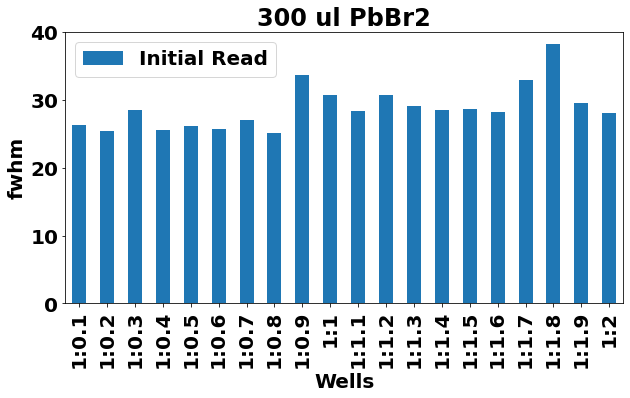

In [34]:

plotdata= fwhm_bar2[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);


ax.set_xlabel("Wells")
ax.set_ylabel("fwhm")
ax.set_xticklabels(fwhm_bar2['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('300 ul PbBr2')

##Position Bar Plot for Final Read

In [35]:
center_bar2= pd.DataFrame(center2)
center_bar2.rename(columns={center_bar2.columns[0]: 'center'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

center_bar2['wells']=wells

print(center_bar2)

        center  wells
0   522.229063  1:0.1
1   523.762864  1:0.2
2   523.367333  1:0.3
3   522.073586  1:0.4
4   522.832379  1:0.5
5   522.622703  1:0.6
6   522.218216  1:0.7
7   521.544064  1:0.8
8   517.883160  1:0.9
9   518.148729    1:1
10  522.163038  1:1.1
11  517.170271  1:1.2
12  515.963791  1:1.3
13  527.046272  1:1.4
14  515.461576  1:1.5
15  516.824391  1:1.6
16  510.638104  1:1.7
17  513.299531  1:1.8
18  515.090965  1:1.9
19  514.157890    1:2
20  515.912037  1:0.1
21  504.563887  1:0.2
22  488.124686  1:0.3
23  500.156536  1:0.4
24  333.377777  1:0.5
25  509.793805  1:0.6
26  413.570327  1:0.7
27  335.923006  1:0.8
28  489.660845  1:0.9
29  397.756525    1:1
30  493.073130  1:1.1
31  511.886782  1:1.2
32  426.327403  1:1.3
33  502.381289  1:1.4
34  399.126396  1:1.5
35  450.642382  1:1.6
36  315.970647  1:1.7
37  508.417191  1:1.8
38  455.548927  1:1.9
39  407.795656    1:2


Text(0.5, 1.0, '300 ul PbBr2')

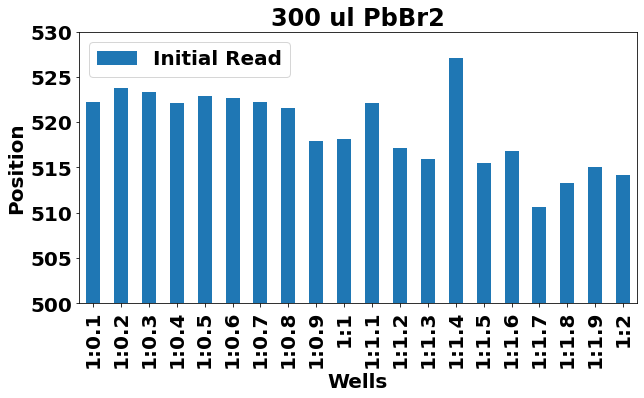

In [36]:

plotdata= center_bar2[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);

plt.ylim([500, 530])
ax.set_xlabel("Wells")
ax.set_ylabel("Position")
ax.set_xticklabels(center_bar2['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('300 ul PbBr2')

##Combined Intial and Final Read

###Combined Intensity Bar Plot

## Code

In [37]:
final_height= np.vstack((height,height2)).T

height_final=pd.DataFrame(final_height)

In [38]:
height_final

0             1
0   22790.709643    600.474405
1   36602.635628   9909.694189
2   54188.246319  10135.139207
3   53170.761463  17573.030522
4   57862.815010  18657.689167
5   60823.503413  18476.316518
6   43780.194513   9114.622960
7   75264.689612  15853.003850
8   25617.088023   4039.333699
9    9533.327962   1198.117427
10  15765.391086   2256.370381
11  11103.445059   2823.777996
12   7501.178067  30572.130808
13  20548.397305  56541.093346
14   1302.250006   8267.977999
15   4669.836931  24144.167062
16    703.310629   3414.026741
17   6250.565955  35491.869343
18   1575.668255   9324.293332
19   1134.707525   8947.752297
20   1144.524240    953.893453
21   8336.696280   1675.177655
22  15602.148770   2262.277956
23  35079.318775   8013.805288
24   1950.588435     65.528147
25  55462.322535  13227.427955
26   5703.461193     58.053018
27    616.391272     69.848359
28  21302.330837   3543.476704
29   1375.018762     59.182863
30  10587.330279    765.749980
31  38289.902601   3228.299193
32  15211.164000     60.110821
33  25337.112970   7719.494517
34   2654.321006     65.847571
35  11316.969976     68.218543
36   2607.317408     97.969951
37   8230.858490    157.703050
38   4338.912509     69.566090
39   2456.583964     67.168407

In [39]:

height_final.rename(columns={height_final.columns[0]: 'Initial Height', height_final.columns[1]:'Final Height'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

height_final['wells']=wells

print(height_final)

    Initial Height  Final Height  wells
0     22790.709643    600.474405  1:0.1
1     36602.635628   9909.694189  1:0.2
2     54188.246319  10135.139207  1:0.3
3     53170.761463  17573.030522  1:0.4
4     57862.815010  18657.689167  1:0.5
5     60823.503413  18476.316518  1:0.6
6     43780.194513   9114.622960  1:0.7
7     75264.689612  15853.003850  1:0.8
8     25617.088023   4039.333699  1:0.9
9      9533.327962   1198.117427    1:1
10    15765.391086   2256.370381  1:1.1
11    11103.445059   2823.777996  1:1.2
12     7501.178067  30572.130808  1:1.3
13    20548.397305  56541.093346  1:1.4
14     1302.250006   8267.977999  1:1.5
15     4669.836931  24144.167062  1:1.6
16      703.310629   3414.026741  1:1.7
17     6250.565955  35491.869343  1:1.8
18     1575.668255   9324.293332  1:1.9
19     1134.707525   8947.752297    1:2
20     1144.524240    953.893453  1:0.1
21     8336.696280   1675.177655  1:0.2
22    15602.148770   2262.277956  1:0.3
23    35079.318775   8013.805288  1:0.4


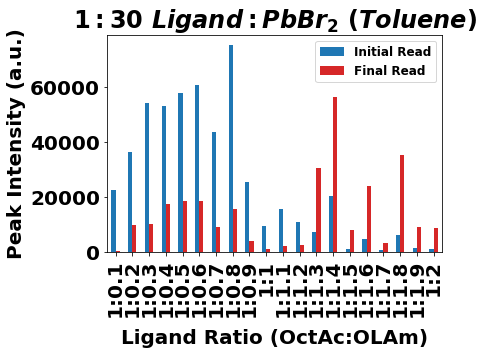

In [40]:


plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plotdata= height_final[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(6,4),cmap=cmap);

ax.set_xlabel("Ligand Ratio (OctAc:OLAm)", labelpad=12, size=20)
ax.set_ylabel("Peak Intensity (a.u.)", size=20)
ax.set_xticklabels(height_final['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'],fontsize=12)

ax.set_title('$1:30$ $Ligand:PbBr_2$ $(Toluene)$')
plt.savefig('300ul Peak Intensity OctA OctAm Tol.tif', bbox_inches='tight',dpi=300)

\

###Combined FWHM Bar Plot

## Code

In [41]:
final_fwhm= np.vstack((fwhm,fwhm2)).T

fwhm_final=pd.DataFrame(final_fwhm)


fwhm_final.rename(columns={fwhm_final.columns[0]: 'Initial FWHM', fwhm_final.columns[1]:'Final FWHM'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

fwhm_final['wells']=wells

print(fwhm_final)

    Initial FWHM  Final FWHM  wells
0      25.358154   26.295814  1:0.1
1      26.692065   25.434106  1:0.2
2      30.339031   28.457273  1:0.3
3      27.894303   25.589678  1:0.4
4      28.514462   26.126496  1:0.5
5      27.851506   25.737885  1:0.6
6      33.518189   27.117474  1:0.7
7      28.294370   25.092105  1:0.8
8      39.478617   33.727544  1:0.9
9      32.868347   30.758273    1:1
10     36.799540   28.444824  1:1.1
11     32.730611   30.773466  1:1.2
12     31.391688   29.155627  1:1.3
13     28.365172   28.602078  1:1.4
14     35.176525   28.734018  1:1.5
15     30.920441   28.192568  1:1.6
16     38.169985   32.966018  1:1.7
17     45.201975   38.206755  1:1.8
18     35.824428   29.549221  1:1.9
19     32.163601   28.077905    1:2
20     29.109954   25.696992  1:0.1
21     26.132218   25.807680  1:0.2
22     25.173283   25.715366  1:0.3
23     25.542033   24.225025  1:0.4
24     31.850517  265.310292  1:0.5
25     25.142120   24.635754  1:0.6
26     26.613494  210.874896

##FWHM bar plot

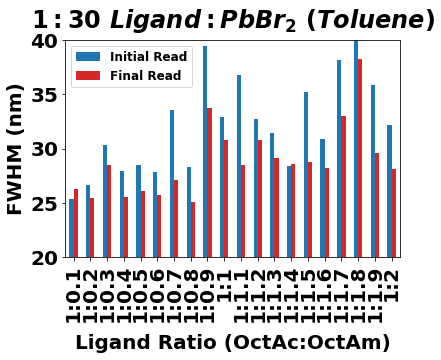

In [42]:

plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plotdata= fwhm_final[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(6,4),cmap=cmap);

plt.ylim([20, 40])
ax.set_xlabel("Ligand Ratio (OctAc:OctAm)", labelpad=12, size=20)
ax.set_ylabel("FWHM (nm)", size=20)
ax.set_xticklabels(fwhm_final['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'],fontsize=12)

ax.set_title('$1:30$ $Ligand:PbBr_2$ $(Toluene)$',pad=12)
plt.savefig('300 ul FWHM OctA OctAm TOl.tif', bbox_inches='tight',dpi=300)

###Combined Peak Position Bar Plot

## Code

In [43]:
final_center= np.vstack((center,center2)).T

center_final=pd.DataFrame(final_center)


center_final.rename(columns={center_final.columns[0]: 'Initial center', center_final.columns[1]:'Final center'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

center_final['wells']=wells

print(center_final)

    Initial center  Final center  wells
0       521.674353    522.229063  1:0.1
1       522.826225    523.762864  1:0.2
2       517.315655    523.367333  1:0.3
3       518.853033    522.073586  1:0.4
4       519.495909    522.832379  1:0.5
5       520.394296    522.622703  1:0.6
6       514.205878    522.218216  1:0.7
7       519.530204    521.544064  1:0.8
8       509.066804    517.883160  1:0.9
9       512.497974    518.148729    1:1
10      510.462068    522.163038  1:1.1
11      512.099467    517.170271  1:1.2
12      513.538652    515.963791  1:1.3
13      519.065899    527.046272  1:1.4
14      508.274417    515.461576  1:1.5
15      513.772368    516.824391  1:1.6
16      501.963382    510.638104  1:1.7
17      509.211562    513.299531  1:1.8
18      507.366750    515.090965  1:1.9
19      509.207343    514.157890    1:2
20      521.648118    515.912037  1:0.1
21      503.899903    504.563887  1:0.2
22      495.683774    488.124686  1:0.3
23      508.558476    500.156536  1:0.4


##Position bar plot

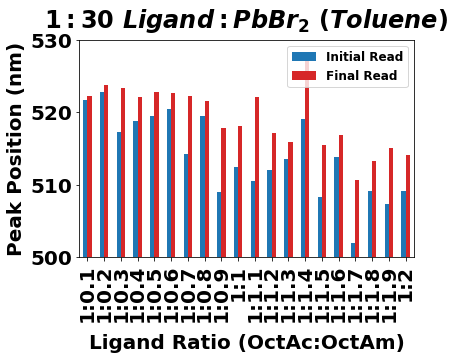

In [44]:

plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plotdata= center_final[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(6,4),cmap=cmap);

plt.ylim([500, 530])
ax.set_xlabel("Ligand Ratio (OctAc:OctAm)", labelpad=12, size=20)
ax.set_ylabel("Peak Position (nm)", size=20)
ax.set_xticklabels(center_final['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'],fontsize=12)
ax.set_title('$1:30$ $Ligand:PbBr_2$ $(Toluene)$',pad=12)
plt.savefig('300 ul Peak Position OctA OctA TOl.tif', bbox_inches='tight',dpi=300)

##Chloroform


##Position bar plot

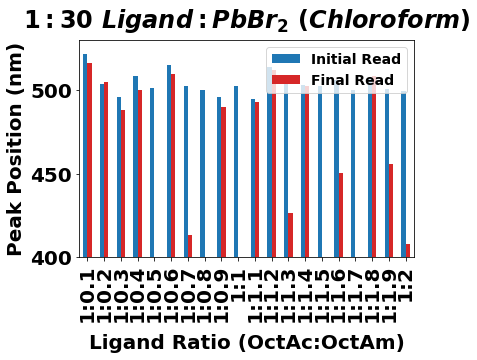

In [48]:

plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plotdata= center_final[20:40]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(6,4),cmap=cmap);

plt.ylim([400, 530])
ax.set_xlabel("Ligand Ratio (OctAc:OctAm)", labelpad=12, size=20)
ax.set_ylabel("Peak Position (nm)", size=20)
ax.set_xticklabels(center_final['wells'].iloc[20:40])
ax.legend(['Initial Read','Final Read'],fontsize=14, loc='upper right')

ax.set_title('$1:30$ $Ligand:PbBr_2$ $(Chloroform)$',pad=12)
plt.savefig('300 ul Peak Position OctA OctAm Chloroform.tif', bbox_inches='tight',dpi=300)

##FWHM bar plot

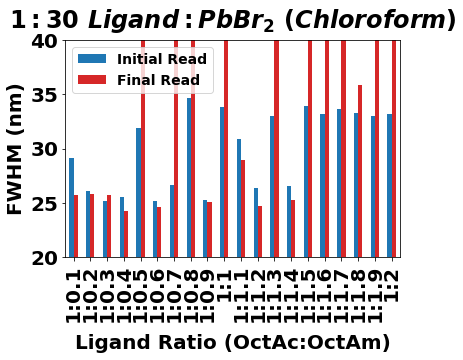

In [49]:

plt.rcParams['legend.title_fontsize'] = 'xx-small'
plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plotdata= fwhm_final[20:40]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(6,4),cmap=cmap);

plt.ylim([20, 40])
ax.set_xlabel("Ligand Ratio (OctAc:OctAm)", labelpad=12, size=20)
ax.set_ylabel("FWHM (nm)", size=20)
ax.set_xticklabels(fwhm_final['wells'].iloc[20:40])
ax.legend(['Initial Read','Final Read'],fontsize=14, loc='upper left')

ax.set_title('$1:30$ $Ligand:PbBr_2$ $(Chloroform)$',pad=12)
plt.savefig('300 ul FWHM OctA OctAm Chloroform.tif', bbox_inches='tight',dpi=300)

###Combined Intensity Bar Plot

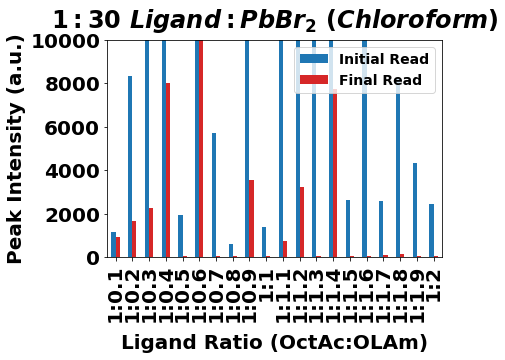

In [47]:
plt.rcParams['legend.title_fontsize'] = 'xx-small'
plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plotdata= height_final[20:40]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(6,4),cmap=cmap);
plt.ylim([0, 10000])
ax.set_xlabel("Ligand Ratio (OctAc:OLAm)", labelpad=12, size=20)
ax.set_ylabel("Peak Intensity (a.u.)", size=20)
ax.set_xticklabels(height_final['wells'].iloc[20:40])

ax.legend(['Initial Read','Final Read'],fontsize=14)

ax.set_title('$1:30$ $Ligand:PbBr_2$ $(Chloroform)$',pad=12)
plt.savefig('300ul Peak Intensity OctA OctAm Chloroform.tif', bbox_inches='tight',dpi=300)